<a href="https://colab.research.google.com/github/aliaghababaee/SLO_Asieh/blob/main/Everything.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
from matplotlib import pyplot as plt, cm
import numpy as np
import cv2

In [2]:
"""

A class to read the raw OCT data (.vol file). This class has four different methods to read header file,
SLO image, Bscans, and corresponding segmentation.

sample to run:

from oct_read import *
oct = OctRead('EYE00003_E_3771_cropped_segmented_corrected.vol')
header = oct.get_oct_hdr()
print(header['Version'])
"""

# import numerical python and structure packages
from struct import unpack
import numpy as np
import os


class OctRead:
    """

    This class will read the .vol file and return header information as a Python dictionary along with
    bscan images, and segmentation data. It also provides thickness grid
    """

    def __init__(self, file_name):

        """

        create the class variable

        :type file_name: str
        :param file_name: the name of the volume file
        """
        self.file_name = file_name

    def get_oct_hdr(self):
        """

        A method to extract the header information from oct volume file

        :returns: a list containing header information
        :rtype: list
        """

        # Read binary file
        with open(self.file_name, mode='rb') as file_name:
            file_content = file_name.read()
            version, size_x, num_b_scans, size_z, scale_x, distance, scale_z, size_x_slo, size_y_slo, scale_x_slo, \
            scale_y_slo, field_size_slo, scan_focus, scan_position, exam_time, scan_pattern, b_scan_hdr_size, id, \
            reference_id, pid, patient_id, padding, dob, vid, visit_id, visit_date, grid_type, grid_offset, grid_type_1, \
            grid_offset_1, prog_id, spare = unpack("=12siiidddiiddid4sQii16s16si21s3sdi24sdiiii34s1790s",
                                                   file_content[:2048])

        # Read raw hdr
        # Format hdr properly
        hdr = {'Version': version.rstrip(),
               'SizeX': size_x,
               'NumBScans': num_b_scans,
               'SizeZ': size_z,
               'ScaleX': scale_x,
               'Distance': distance,
               'ScaleZ': scale_z,
               'SizeXSlo': size_x_slo,
               'SizeYSlo': size_y_slo,
               'ScaleXSlo': scale_x_slo,
               'ScaleYSlo': size_y_slo,
               'FieldSizeSlo': field_size_slo,
               'ScanFocus': scan_focus,
               'ScanPosition': scan_position.rstrip(),
               'ExamTime': exam_time,
               'ScanPattern': scan_pattern,
               'BScanHdrSize': b_scan_hdr_size,
               'ID': id.rstrip(),
               'ReferenceID': reference_id.rstrip(),
               'PID': pid,
               'PatientID': patient_id.rstrip(),
               'DOB': dob,
               'VID': vid,
               'VisitID': visit_id.rstrip(),
               'VisitDate': visit_date,
               'GridType': grid_type,
               'GridOffset': grid_offset,
               'GridType1': grid_type_1,
               'GridOffset1': grid_offset_1,
               'ProgID': prog_id.rstrip()}
        return hdr

    def get_thickness_grid(self, hdr):

        """
        Read the EDTRS thickness grid information from the vol file

        :type hdr: list
        :param hdr: header file
        :returns: thickness grid
        :rtype: list
        """
        # offset for the corresponding data
        grid_offset = hdr['GridOffset']

        # Type of the EDTRS grid with different diameters
        grid_type = hdr['GridType']

        # if zero then grid information are not available
        if grid_type != 0:

            # Read the vol file as a binary file from the offset point
            f = open(self.file_name, "rb")
            f.seek(grid_offset, os.SEEK_SET)

            # Read the thickness grid related information from vol file
            thickness_type = np.fromfile(f, dtype='int32', count=1)
            thickness_dia = np.fromfile(f, dtype='double', count=3)
            thickness_center_pos = np.fromfile(f, dtype='double', count=2)
            thickness_center_thick = np.fromfile(f, dtype='float32', count=1)
            thickness_min_center_thick = np.fromfile(f, dtype='float32', count=1)
            thickness_max_center_thick = np.fromfile(f, dtype='float32', count=1)
            thickness_total_vol = np.fromfile(f, dtype='float32', count=1)
            thickness_sector = np.zeros([9, 2], dtype='float')
            for i in range(9):
                thickness_sector[i, 0] = np.fromfile(f, dtype='float32', count=1)
                thickness_sector[i, 1] = np.fromfile(f, dtype='float32', count=1)

            # Format the data properly
            thickness_grid = {'Type': thickness_type,
                              'Diameter': thickness_dia,
                              'CenterPos': thickness_center_pos,
                              'CenterThick': thickness_center_thick,
                              'MinCentralThick': thickness_min_center_thick,
                              'MaxCentralThick': thickness_max_center_thick,
                              'TotalVolume': thickness_total_vol,
                              'ThicknessSectors': thickness_sector}

        return thickness_grid

    def get_slo_image(self, hdr):

        """

        Read the SLO image stored in the  .vol file and returns it as a Numpy array.

        :type hdr: list
        :param hdr: header file, which is the output of the first method of the class.
        :returns: slo image
        :rtype: int
        """

        # Size of the SLO image
        size_x_slo = hdr['SizeXSlo']
        size_y_slo = hdr['SizeYSlo']
        slo_size = size_x_slo * size_y_slo

        # Offset value before the SLO image
        slo_offset = 2048

        # Read the vol file as a binary file from the offset point
        f = open(self.file_name, "rb")
        f.seek(slo_offset, os.SEEK_SET)

        # Convert the data into proper format
        slo_img = np.fromfile(f, dtype=np.uint8, count=slo_size)

        # Convert the read data into matrix (array) form and return the image value
        slo_img = slo_img.reshape(size_x_slo, size_y_slo)
        return slo_img

    def get_b_scans(self, hdr):
        """

        method to read the bscan images from the raw vol file.

        :type hdr: list
        :param hdr: header file, which is the output of the first method of the class.
        :returns: bscan images
        :rtype: float
        """
        # Read the size of the 3D image stack.
        size_x = hdr['SizeX']
        size_y = hdr['NumBScans']
        size_z = hdr['SizeZ']

        # Create and empty 3D array to store the bscans stack.
        b_scans_stack = np.zeros([size_z, size_x, size_y], dtype='float')

        # Get the size of the SLO image and also the size of the bscan header.
        size_x_slo = hdr['SizeXSlo']
        size_y_slo = hdr['SizeYSlo']
        b_scan_hdr_size = hdr['BScanHdrSize']

        # Size of a single bscan.
        loc_size = (size_x * size_z)

        # read the file as a binary file.
        f = open(self.file_name, "rb")

        # Get the data regarding each bscan.
        for i in range(size_y):
            # Offset value for each bscan.
            b_scan_offset = 2048 + b_scan_hdr_size + (size_x_slo * size_y_slo) + (
                        i * (b_scan_hdr_size + size_x * size_z * 4))

            # Read the corresponding bscan data.
            f.seek(b_scan_offset, os.SEEK_SET)
            b_scan = np.fromfile(f, '<f', count=loc_size)

            # Reshape in matrix format.
            b_scan = np.asarray(b_scan, 'f')
            b_scan = b_scan.reshape(size_z, size_x)

            # Convert into standard pixel data.
            b_scan = np.multiply((b_scan ** 0.25), 255)

            # Store in the stack.
            b_scans_stack[:, :, i] = b_scan
        return b_scans_stack

    def get_segmentation(self, hdr):
        """

        method to read the segmentation corresponding to the different layers of the retina from the raw vol file.

        :type hdr: list
        :param hdr: header file, which is the output of the first method of the class.
        :returns: bscan images
        :rtype: float
        """
        # Size of the bscan stack
        size_x = hdr['SizeX']
        size_y = hdr['NumBScans']
        size_z = hdr['SizeZ']

        # Size of the SLO image
        size_x_slo = hdr['SizeXSlo']
        size_y_slo = hdr['SizeYSlo']
        b_scan_hdr_size = hdr['BScanHdrSize']

        # Binary data
        f = open(self.file_name, "rb")

        # Arrays to keep the boundary information of the segmentation
        b_scan_hdr_size_array = np.zeros([size_y, 1], dtype='int32')
        start_x = np.zeros([size_y, 1], dtype='double')
        start_y = np.zeros([size_y, 1], dtype='double')
        end_x = np.zeros([size_y, 1], dtype='double')
        end_y = np.zeros([size_y, 1], dtype='double')
        num_seg = np.zeros([size_y, 1], dtype='int32')
        off_seg = np.zeros([size_y, 1], dtype='int32')
        quality = np.zeros([size_y, 1], dtype='float32')
        shift = np.zeros([size_y, 1], dtype='int32')

        # create an empty stack for segmentation line
        b_scans_segments = np.zeros([size_x, 17, size_y], dtype='float')

        # read the segmentation lines
        for i in range(size_y):
            # offset regarding the each scan and then read
            seg_offset = 12 + 2048 + (size_x_slo * size_y_slo) + (i * (b_scan_hdr_size + size_x * size_z * 4))
            f.seek(seg_offset, os.SEEK_SET)

            # Boundary points of the segments
            b_scan_hdr_size_array[i] = np.fromfile(f, dtype='int32', count=1)
            start_x[i] = np.fromfile(f, dtype='double', count=1)
            start_y[i] = np.fromfile(f, dtype='double', count=1)
            end_x[i] = np.fromfile(f, dtype='double', count=1)
            end_y[i] = np.fromfile(f, dtype='double', count=1)

            # number of segment layers
            num_seg[i] = np.fromfile(f, dtype=np.int32, count=1)

            # Offset to read the segment
            off_seg[i] = np.fromfile(f, dtype='int32', count=1)

            # Other params
            quality[i] = np.fromfile(f, dtype='float32', count=1)
            shift[i] = np.fromfile(f, dtype='int32', count=1)
            spare = np.fromfile(f, dtype='int8', count=192)
            # print('spare' + spare[i])

            seg_offset = 256 + 2048 + (size_x_slo * size_y_slo) + (i * (b_scan_hdr_size + size_x * size_z * 4))
            f.seek(seg_offset, os.SEEK_SET)
            first_seg = np.fromfile(f, '<f', count=num_seg[i, 0] * size_x)

            # maximum intensity of the segmentation and total number of points
            seg_max = (max(first_seg))
            num_points = num_seg[i, 0] * size_x

            # Remove outliers
            for k in range(num_points):
                if first_seg[k] == seg_max:
                    first_seg[k] = float('nan')

            # Store in the stack
            for j in range(num_seg[i, 0]):
                b_scans_segments[:, j, i] = first_seg[j * size_x:(j + 1) * size_x]

        # Format the data properly
        seg_data_full = {'startX': start_x,
                         'startY': start_y,
                         'endX': end_x,
                         'endY': end_y,
                         'segNumbers': num_seg,
                         'offsetSeg': off_seg,
                         'Quality': quality,
                         'Shift': shift,
                         'SegLayers': b_scans_segments}
        return seg_data_full



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/merged_data_final2.zip

Archive:  /content/drive/MyDrive/merged_data_final2.zip
 extracting: test_merged.pkl         
 extracting: test_merged_label.pkl   
 extracting: train_merged.pkl        
 extracting: train_merged_label.pkl  


In [ ]:
!unzip /content/drive/MyDrive/new_test_merged_data.zip

Archive:  /content/drive/MyDrive/new_test_merged_data.zip
replace test_merged.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: test_merged.pkl         
replace test_merged_label.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: test_merged_label.pkl   


In [ ]:
!unzip /content/drive/MyDrive/merged_data_finalllll.zip

Archive:  /content/drive/MyDrive/merged_data_finalllll.zip
replace test_merged.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: test_merged2.pkl
 extracting: test_merged2.pkl        
replace test_merged_label.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: test_merged_label2.pkl
 extracting: test_merged_label2.pkl  
replace train_merged.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: train_merged2.pkl
 extracting: train_merged2.pkl       
replace train_merged_label.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: train_merged_label2.pkl
 extracting: train_merged_label2.pkl  


NameError: name 'train_merged' is not defined

In [ ]:
tr1 = pickle.load (open ('/content/train_merged.pkl', 'rb'))
tr2 = pickle.load (open ('/content/train_merged2.pkl', 'rb'))

In [ ]:
te1 = pickle.load (open ('/content/test_merged.pkl', 'rb'))
te2 = pickle.load (open ('/content/test_merged2.pkl', 'rb'))

In [ ]:
trl1 = pickle.load (open ('/content/train_merged_label.pkl', 'rb'))
trl2 = pickle.load (open ('/content/train_merged_label2.pkl', 'rb'))

In [ ]:
tel1 = pickle.load (open ('/content/test_merged_label.pkl', 'rb'))
tel2 = pickle.load (open ('/content/test_merged_label2.pkl', 'rb'))

In [ ]:
trl1

0

In [ ]:
s = 0
for i in tel1:
  if tel1 [i] == tel2 [i]:
          s+=1

In [ ]:
s

21

In [ ]:
s = 0
for i in trl1:
  for j in range (len (trl1 [i])):
    for m in range (len (trl1 [i] [j] [1])):
      for n in range (len (trl1 [i] [j] [1] [m])):
        if trl1 [i] [j] [1] [m] [n] [0] == trl2 [i] [j] [1] [m] [n] [0]:
          s+=1

TypeError: object of type 'int' has no len()

In [ ]:
s

3256320

In [ ]:
!unzip /content/drive/MyDrive/Iran2.zip

Archive:  /content/drive/MyDrive/Iran2.zip
   creating: Iran2/
  inflating: Iran2/EYE00084_E_3408_cropped_segmented_corrected.vol  
  inflating: Iran2/EYE00173_E_820_cropped_segmented_corrected.vol  

In [ ]:
oct = OctRead ('/content/Iran2/EYE00003_E_3771_cropped_segmented_corrected.vol')

In [ ]:
hdr = oct.get_oct_hdr ()

In [ ]:
seg = oct.get_segmentation (hdr) ['SegLayers']

In [ ]:
seg.shape

(523, 17, 49)

In [ ]:
train_thickness = pickle.load (open ('/content/train_layers_iran.pkl', 'rb'))

In [ ]:
train_sp = pickle.load (open ('/content/train_sp_iran.pkl', 'rb'))

In [ ]:
!unzip /content/drive/MyDrive/train_thickness_retina_iran.zip

Archive:  /content/drive/MyDrive/train_thickness_retina_iran.zip
 extracting: train_labels.pkl        
 extracting: train_thickness_retina.pkl  
 extracting: train_sp.pkl            


In [ ]:
train_sp_thick = pickle.load (open ('/content/train_sp.pkl', 'rb'))

In [ ]:
train_sp_fals = pickle.load (open ('/content/train_sp_iran.pkl', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/content/train_sp_iran.pkl'

In [ ]:
train_thickness = pickle.load (open ('/content/train_thickness_retina.pkl', 'rb'))

In [ ]:
train_labels_thick = pickle.load (open ('/content/train_labels.pkl', 'rb'))

In [ ]:
!unzip /content/drive/MyDrive/test_thickness_retina_iran.zip

Archive:  /content/drive/MyDrive/test_thickness_retina_iran.zip
 extracting: test_labels.pkl         
 extracting: test_thickness_retina.pkl  
 extracting: test_sp.pkl             


In [ ]:
test_sp_thick = pickle.load (open ('/content/test_sp.pkl', 'rb'))

In [ ]:
test_thickness = pickle.load (open ('/content/test_thickness_retina.pkl', 'rb'))

In [ ]:
test_labels_thick = pickle.load (open ('/content/test_labels.pkl', 'rb'))

In [ ]:
train_sp_thick

In [ ]:
!unzip /content/drive/MyDrive/train_SLO_iran.zip

Archive:  /content/drive/MyDrive/train_SLO_iran.zip
 extracting: train_slo_iran.pkl      
 extracting: train_labels_Iran.pkl   
 extracting: train_sp_iran.pkl       


In [ ]:
!unzip /content/drive/MyDrive/test_SLO_iran.zip

Archive:  /content/drive/MyDrive/test_SLO_iran.zip
 extracting: test_slo_iran.pkl       
 extracting: test_labels_Iran.pkl    
 extracting: test_sp_iran.pkl        


In [ ]:
train_slo = pickle.load (open ('/content/train_slo_iran.pkl', 'rb'))

In [ ]:
test_slo = pickle.load (open ('/content/test_slo_iran.pkl', 'rb'))

In [ ]:
train_sp_slo = pickle.load (open ('/content/train_sp_iran.pkl', 'rb'))

In [ ]:
test_sp_slo = pickle.load (open ('/content/test_sp_iran.pkl', 'rb'))

In [ ]:
train_labels_slo = pickle.load (open ('/content/train_labels_Iran.pkl', 'rb'))

In [ ]:
test_labels_slo = pickle.load (open ('/content/test_labels_Iran.pkl', 'rb'))

In [ ]:
from skimage.transform import resize

In [ ]:
train_slo_new = {}

im_size = 128

for key in train_slo:

  train_slo_new [key] = []

  for i in range (len(train_slo [key])):

    slo = resize (train_slo [key] [i], (im_size, im_size, 1), mode = 'constant', preserve_range = True)

    slo = np.flip (slo, axis = 1) if train_sp_slo [key] [i] == False else slo

    train_slo_new [key].append (slo)

In [ ]:
test_slo_new = {}

im_size = 128

for key in test_slo:

  test_slo_new [key] = []

  for i in range (len (test_slo [key])):

    slo = resize (test_slo [key] [i], (im_size, im_size, 1), mode = 'constant', preserve_range = True)

    slo = np.flip (slo, axis = 1) if test_sp_slo [key] [i] == False else slo

    test_slo_new [key].append (slo)

In [ ]:
test_slo_new ['1'] [0].shape

(128, 128, 1)

In [ ]:
test_thickness_new = pickle.load (open ('/content/drive/MyDrive/test_thickness_new.pkl', 'rb'))

In [ ]:
train_merged = {}

train_merged_label = {}

len_slo = 0

for subject in train_slo_new:


  train_merged [subject] = []

  if len (train_thickness [subject]) == 2 or len (train_thickness [subject]) == 3:

    for i,_ in enumerate(train_slo_new [subject]):

      for j,_ in enumerate(train_thickness [subject]):

        if train_sp_slo [subject] [i] == train_sp_thick [subject] [j]:

          train_merged [subject].append ([train_slo_new [subject] [i], train_thickness [subject] [j]])

          len_slo += 1

  elif len (train_thickness [subject]) == 1:

    for i,_ in enumerate(train_slo_new [subject]):

      train_merged [subject].append ([train_slo_new [subject] [i], train_thickness [subject] [0]])

      s+=1

  train_merged_label [subject] = train_labels_slo [subject]

In [ ]:
s = 0
for key in train_merged:

  s += len (train_merged [key])

print (i)

212


In [ ]:
s=

81

In [ ]:
!unzip /content/drive/MyDrive/merged_data_final2.zip

Archive:  /content/drive/MyDrive/merged_data_final2.zip
 extracting: test_merged.pkl         
 extracting: test_merged_label.pkl   
 extracting: train_merged.pkl        
 extracting: train_merged_label.pkl  


In [ ]:
!unzip /content/drive/MyDrive/merged_data_final.zip

Archive:  /content/drive/MyDrive/merged_data_final.zip
 extracting: test_slo_thick.pkl      
 extracting: test_slo_thick_labels.pkl  
 extracting: train_slo_thick.pkl     
 extracting: train_slo_thick_labels.pkl  


In [ ]:
train_slo_thick = pickle.load (open ('/content/train_slo_thick.pkl', 'rb'))

In [ ]:
train_merged = pickle.load (open ('/content/train_merged.pkl', 'rb'))

In [ ]:
train_slo_thick == train_merged

False

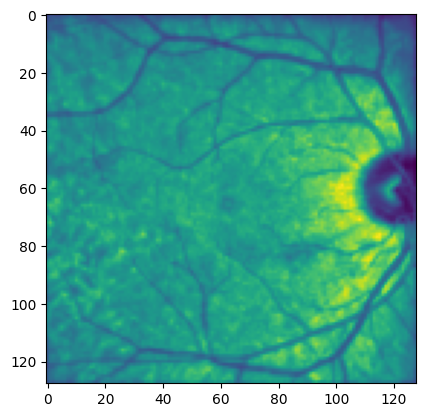

In [ ]:
plt.imshow (train_slo_thick ['0'] [0] [:,:, 0])

In [ ]:
test_merged = {}

test_merged_label = {}



for subject in test_slo_new:


  test_merged [subject] = []

  if len (test_thickness_new [subject]) == 2:

    for i,_ in enumerate(test_slo_new [subject]):

      for j,_ in enumerate(test_thickness_new [subject]):

        if test_sp_slo [subject] [i] == test_sp_thick [subject] [j]:

          test_merged [subject].append ([test_slo_new [subject] [i], test_thickness_new [subject] [j]])


  elif len (test_thickness_new [subject]) == 1:

    for i,_ in enumerate(test_slo_new [subject]):

      test_merged [subject].append ([test_slo_new [subject] [i], test_thickness_new [subject] [0]])

  test_merged_label [subject] = test_labels_slo [subject]

In [ ]:
test_merged_label ['1']

0

In [ ]:
train_thickness ['0'] [0].shape

In [ ]:
s= 0
for i in test_merged:
  s += len (test_merged [i])
print (s)

56


In [ ]:
test_merged_label

In [ ]:
with open ('/content/train_merged.pkl', 'wb') as f:

  pickle.dump (train_merged, f)

In [ ]:
with open ('/content/train_merged_label.pkl', 'wb') as f:

  pickle.dump (train_merged_label, f)

In [ ]:
with open ('/content/test_merged_label.pkl', 'wb') as f:

  pickle.dump (test_merged_label, f)

In [ ]:
with open ('/content/test_merged.pkl', 'wb') as f:

  pickle.dump (test_merged, f)

In [ ]:
train_merge = {}
train_merge_labels = {}

for key in enumerate(train_slo):

  train_merge [key] = []






In [ ]:
test_slo_sp

{'1': [True, False],
 '3': [True, False],
 '6': [True, False],
 '9': [True, False],
 '11': [True, False],
 '13': [True, False],
 '17': [True, False, False, False, True],
 '18': [True, False, True, False],
 '19': [True, False, True, False],
 '20': [True, False, True, False],
 '23': [True, False, True, False],
 '30': [True, False, True, False],
 '32': [True, False, False, True],
 '56': [True, False],
 '66': [True, False],
 '68': [True, False],
 '70': [True, False],
 '72': [True, False],
 '85': [True, False],
 '93': [True, False],
 '96': [True]}

In [ ]:
test_sp_thick

{'1': [True, False],
 '3': [False],
 '6': [True, False],
 '9': [False],
 '11': [True],
 '13': [True, False],
 '17': [True, False],
 '18': [True, False],
 '19': [True, False],
 '20': [True, False],
 '23': [True, False],
 '30': [True, False],
 '32': [True, False],
 '56': [False, True],
 '66': [False, True],
 '68': [False, True],
 '70': [False, True],
 '72': [False, True],
 '85': [False, True],
 '93': [False, True],
 '96': [False]}

In [ ]:
for i in train_sp_corr:
  if len (train_sp_corr [i]) == 1 and len (train_slo_sp [i]) != 1:
    print (i)


In [ ]:
s = 0
for i in train_merged:

  if len (train_merged [i]) == 1:

    print (i)

7
8
61
71
83
95
101


In [ ]:
train_merged [i] [0] [1].shape

(60, 256, 1)

In [ ]:
train_sp_thick

{'0': [False],
 '2': [True, False],
 '4': [False],
 '5': [True, False],
 '7': [True],
 '8': [False],
 '10': [False],
 '12': [False],
 '14': [True, False],
 '15': [True],
 '16': [True, False],
 '21': [True, False],
 '22': [True, False, True],
 '24': [False, True],
 '25': [True],
 '26': [True, False],
 '27': [True, False],
 '28': [True, False],
 '29': [True, False],
 '31': [True, False],
 '33': [False],
 '34': [True, False],
 '35': [True, False],
 '36': [True],
 '37': [True, False],
 '38': [True],
 '39': [True, False],
 '40': [True, False],
 '41': [True, False],
 '42': [True, False],
 '43': [True],
 '44': [True, False],
 '45': [True, False],
 '46': [True, False],
 '47': [True, False],
 '48': [True, False],
 '49': [False, True],
 '50': [True, False],
 '51': [False, True],
 '52': [False, True],
 '53': [False, True],
 '54': [False, True],
 '55': [False, True],
 '57': [False, True],
 '58': [False, True],
 '59': [False, True],
 '60': [False, True],
 '61': [True],
 '62': [False, True],
 '63': 

In [ ]:
for key in train_sp_thick:
  if len (train_sp_thick [key]) == 1 and len (train_slo_sp [key]) >2:
    print (key)

25
33
36
38
43


In [ ]:
train_slo_sp

{'0': [True, False],
 '2': [True, False],
 '4': [False, True],
 '5': [True, False],
 '7': [True],
 '8': [False],
 '10': [True, False],
 '12': [True, False],
 '14': [True, False],
 '15': [True, False],
 '16': [True, False],
 '21': [True, False, True, False],
 '22': [True, False, True, True, False],
 '24': [False, True, False, True],
 '25': [True, False, True, False],
 '26': [True, False, True, False],
 '27': [True, False, True, False],
 '28': [True, False, False, True],
 '29': [True, False, True, False],
 '31': [True, False, True, False],
 '33': [True, False, True, False],
 '34': [True, False, True, False],
 '35': [True, False, True, False],
 '36': [True, False, True, False],
 '37': [True, False, True, False],
 '38': [True, False, True, False],
 '39': [True, False, True, False],
 '40': [True, False, True, False],
 '41': [True, False, False, True],
 '42': [True, False, True, False],
 '43': [True, False, False, False, True, True, True],
 '44': [True, False, False, True],
 '45': [True, Fal

In [ ]:
!unzip /content/drive/MyDrive/Iran_data.zip

Archive:  /content/drive/MyDrive/Iran_data.zip
 extracting: layers_Iran.pkl         
 extracting: ScanPositionIran.pkl    
 extracting: subjects_index_Iran.pkl  
 extracting: subjects_labels_Iran.pkl  
 extracting: subjects_layers_Iran.pkl  
 extracting: vol_Iran.pkl            
 extracting: vol_labels_Iran.pkl     
 extracting: readme.docx             


In [ ]:
vol_oct = pickle.load (open ('/content/vol_Iran.pkl', 'rb'))

In [ ]:
vol_oct

In [ ]:
vols_slo = pickle.load (open ('/content/drive/MyDrive/vol_slo.pkl', 'rb'))

In [ ]:
vols_slo

In [ ]:
s= 0
for i in vols_slo:
  s += len (vols_slo [i])

In [ ]:
print (s)

265


In [ ]:
s = 0
for i in test_slo:
  s += len (test_slo [i])
print (s)

56


In [ ]:
train_slo.keys ()

dict_keys(['0', '2', '4', '5', '7', '8', '10', '12', '14', '15', '16', '21', '22', '24', '25', '26', '27', '28', '29', '31', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '57', '58', '59', '60', '61', '62', '63', '64', '65', '67', '69', '71', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '86', '87', '88', '89', '90', '91', '92', '94', '95', '97', '98', '99', '100', '101'])

In [ ]:
train_thickness.keys ()

dict_keys(['0', '2', '4', '5', '7', '8', '10', '12', '14', '15', '16', '21', '22', '24', '25', '26', '27', '28', '29', '31', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '57', '58', '59', '60', '61', '62', '63', '64', '65', '67', '69', '71', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '86', '87', '88', '89', '90', '91', '92', '94', '95', '97', '98', '99', '100', '101'])

In [ ]:
!unzip /content/drive/MyDrive/test_thickness_retina_iran.zip

Archive:  /content/drive/MyDrive/test_thickness_retina_iran.zip
 extracting: test_labels.pkl         
 extracting: test_thickness_retina.pkl  
 extracting: test_sp.pkl             


In [ ]:
test_sp_corr = pickle.load (open ('/content/test_sp.pkl', 'rb'))

In [ ]:
test_thickness = pickle.load (open ('/content/test_thickness_retina.pkl', 'rb'))

In [ ]:
test_labels = pickle.load (open ('/content/test_labels.pkl', 'rb'))

In [ ]:
s = 0
for i in test_thickness:
 s+= len (test_thickness [i])
print (s)

38


In [ ]:
subjects

In [ ]:
vols

In [ ]:
train_thickness ['4'] [0].shape

(60, 256, 1)

In [ ]:
train_sp_fals

In [ ]:
train_sp_corr

In [ ]:
!unzip /content/drive/MyDrive/Iran2.zip

In [ ]:
!unzip /content/drive/MyDrive/Iran_data.zip

Archive:  /content/drive/MyDrive/Iran_data.zip
 extracting: layers_Iran.pkl         
 extracting: ScanPositionIran.pkl    
 extracting: subjects_index_Iran.pkl  
 extracting: subjects_labels_Iran.pkl  
 extracting: subjects_layers_Iran.pkl  
 extracting: vol_Iran.pkl            
 extracting: vol_labels_Iran.pkl     
 extracting: readme.docx             


In [ ]:
subjects = pickle.load (open ('/content/subjects_index_Iran.pkl', 'rb'))
vols = pickle.load (open ('/content/vol_Iran.pkl', 'rb'))

In [ ]:
subjects

In [ ]:
vols

In [ ]:
oct = OctRead ('/content/Iran2/EYE00003_E_3771_cropped_segmented_corrected.vol')

In [ ]:
hdr = oct.get_oct_hdr ()

In [ ]:
hdr ['ScanPosition']

b'OD\x00\x00'

In [ ]:
from skimage.transform import resize

In [ ]:
train_layers ['101'] [0].shape

(1, 521, 49, 9)

In [ ]:
train_layers

In [ ]:
figure = plt.figure (figsize = (32, 32))

key_list = list (train_layers.keys ()) [49:]

num_cols = 10

fig, axs = plt.subplots(num_cols, num_cols)

col = 0
row = 0

for key in key_list:

  for j, image in enumerate(train_layers [str (key)]):

    ax = axs [row] [col]

    ax.imshow (resize (image [0, :,:, 1] - image [0,:,:,0], (128, 128)), cmap = 'jet')

    col+=1

    if col == num_cols:

            col = 0
            row += 1

In [ ]:
plt.imshow (resize (train_layers ['101']  [0] [0,:,:,8] - train_layers ['101']  [0] [0,:,:,0] , (128, 128)), cmap = 'jet')

In [ ]:
vol_slo

In [ ]:
imgs_second = {}

num_layers = 17


for file in sorted (os.listdir ('/content/Iran2')) [:20]:

    imgs_second [file] = []

    path = os.path.join ('/content/Iran2', file)

    oct = OctRead (path)

    hdr = oct.get_oct_hdr ()

    seg = oct.get_segmentation (hdr) ['SegLayers']

    for layer in range (num_layers):

      img = cv2.resize (seg [:, layer, :], (200, 200))

      imgs_second [file].append (img)

In [ ]:
!unzip /content/drive/MyDrive/train_boundary_Iran.zip

Archive:  /content/drive/MyDrive/train_boundary_Iran.zip
 extracting: train_labels_Iran.pkl   
 extracting: train_layers_iran.pkl   
 extracting: train_sp_iran.pkl       


In [ ]:
!unzip /content/drive/MyDrive/Iran_data.zip

In [ ]:
with open ('/content/ScanPositionIran.pkl', 'rb') as f:
  sp = pickle.load (f)

In [ ]:
with open ('/content/subjects_index_Iran.pkl', 'rb') as f:
  subjects = pickle.load (f)

In [ ]:
with open ('/content/vol_Iran.pkl', 'rb') as f:
  vols = pickle.load (f)

In [ ]:
with open ('/content/subjects_labels_Iran.pkl', 'rb') as f:
  labels = pickle.load (f)

In [ ]:
s = 0
for i in labels:

  if labels [i] == 0:

    s+= 1

print (s)

70


In [ ]:
train_thickness_np = np.load ('/content/drive/MyDrive/ThicknessMaps_of_train.npy')

In [ ]:
test_thickness_np = np.load ('/content/drive/MyDrive/ThicknessMaps_of_test.npy')

In [ ]:
!unzip /content/drive/MyDrive/test_boundary_Iran.zip
!unzip /content/drive/MyDrive/train_boundary_Iran.zip

Archive:  /content/drive/MyDrive/test_boundary_Iran.zip
 extracting: test_labels_Iran.pkl    
 extracting: test_layers_iran.pkl    
 extracting: test_sp_iran.pkl        
Archive:  /content/drive/MyDrive/train_boundary_Iran.zip
 extracting: train_labels_Iran.pkl   
 extracting: train_layers_iran.pkl   
 extracting: train_sp_iran.pkl       


In [ ]:
train_thickness = pickle.load (open ('/content/train_layers_iran.pkl', 'rb'))

In [ ]:
test_thickness = pickle.load (open ('/content/test_layers_iran.pkl', 'rb'))

In [ ]:
test_thickness ['1'] [0].shape

(1, 19, 511, 9)

In [ ]:
train_labels = pickle.load (open ('/content/train_labels_Iran.pkl', 'rb'))

In [ ]:
test_labels = pickle.load (open ('/content/test_labels_Iran.pkl', 'rb'))

In [ ]:
a = []

In [ ]:
a = [1, 2, 3]

In [ ]:
a

[1, 2, 3]

In [ ]:
train_thickness_new = {}
for i in train_thickness:
  train_thickness_new [i] = []
  for j in train_thickness [i]:
    train_thickness_new [i].append (np.array ([]))

In [ ]:
test_thickness_new = {}
for i in test_thickness:
  test_thickness_new [i] = []
  for j in test_thickness [i]:
    test_thickness_new [i].append (np.array ([]))

In [ ]:
train_thickness_np

In [ ]:
l = 0

for i in train_thickness_new:

  for j, _ in enumerate(train_thickness_new [i]):

    train_thickness_new [i] [j] = train_thickness_np [l]

    l += 1


In [ ]:
train_thickness_new ['101'] [0].shape

(60, 256, 1)

In [ ]:
test_thickness_new = {}
for i in test_thickness:
  test_thickness_new [i] = []
  for j in test_thickness [i]:
    test_thickness_new [i].append (np.array ([]))

In [ ]:
l = 0

for i in test_thickness_new:

  for j, _ in enumerate(test_thickness_new [i]):

    test_thickness_new [i] [j] = test_thickness_np [l]

    l += 1


In [ ]:
test_thickness_new ['1'] [0]

array([[[0.20930481],
        [0.20930481],
        [0.20930481],
        ...,
        [0.46789694],
        [0.44800523],
        [0.43802053]],

       [[0.20930481],
        [0.20930481],
        [0.20930481],
        ...,
        [0.46789694],
        [0.44800523],
        [0.43802053]],

       [[0.16289088],
        [0.16862464],
        [0.17449437],
        ...,
        [0.63034588],
        [0.62205768],
        [0.45770347]],

       ...,

       [[0.07175936],
        [0.06873707],
        [0.06177465],
        ...,
        [0.50270736],
        [0.50154668],
        [0.09617876]],

       [[0.06015589],
        [0.06000048],
        [0.05017119],
        ...,
        [0.46789694],
        [0.45806766],
        [0.05852415]],

       [[0.06015589],
        [0.06000048],
        [0.05017119],
        ...,
        [0.46789694],
        [0.45806766],
        [0.05852415]]])

In [ ]:
l

In [ ]:
with open ('/content/test_thickness_new.pkl', 'wb') as f:
  pickle.dump (test_thickness_new, f)

In [ ]:
!cp /content/test_thickness_new.pkl /content/drive/MyDrive

In [ ]:

train_sp = pickle.load (open ('/content/train_sp_iran.pkl', 'rb'))
test_sp = pickle.load (open ('/content/test_sp_iran.pkl', 'rb'))

In [ ]:
train_sp_new = {}
for i in train_sp:
  train_sp_new [i] = []
  for j in train_sp [i]:
    train_sp_new [i].append (np.array ([]))

In [ ]:
test_sp_new = {}
for i in test_sp:
  test_sp_new [i] = []
  for j in test_sp [i]:
    test_sp_new [i].append (np.array ([]))

In [ ]:
test_sp.keys ()

dict_keys(['1', '3', '6', '9', '11', '13', '17', '18', '19', '20', '23', '30', '32', '56', '66', '68', '70', '72', '85', '93', '96'])

In [ ]:
test_sp_copy = test_sp.copy ()

In [ ]:
keys_to_delete = ['1', '3', '6', '9', '11', '13', '17', '18', '19', '20', '23', '30', '32']

In [ ]:
len (keys_to_delete)

13

In [ ]:
plt.imshow (train_thickness_new ['10'] [0])

In [ ]:
test_sp_copy

In [ ]:
for key in test_sp:

  if key in keys_to_delete:

    del test_sp_copy [key]

In [ ]:
test_sp_copy

In [ ]:
test_sp_new = {}

for i in test_sp_copy:

    test_sp_new [i] = [not element for element in test_sp_copy [i]]

In [ ]:
test_sp_new

{'56': [False, True],
 '66': [False, True],
 '68': [False, True],
 '70': [False, True],
 '72': [False, True],
 '85': [False, True],
 '93': [False, True],
 '96': [False]}

In [ ]:
test_sp_all = test_sp.copy ()

In [ ]:
test_sp_all.update (test_sp_new)


In [ ]:
test_sp

{'1': [True, False],
 '3': [False],
 '6': [True, False],
 '9': [False],
 '11': [True],
 '13': [True, False],
 '17': [True, False],
 '18': [True, False],
 '19': [True, False],
 '20': [True, False],
 '23': [True, False],
 '30': [True, False],
 '32': [True, False],
 '56': [True, False],
 '66': [True, False],
 '68': [True, False],
 '70': [True, False],
 '72': [True, False],
 '85': [True, False],
 '93': [True, False],
 '96': [True]}

In [ ]:
test_sp_all

{'1': [True, False],
 '3': [False],
 '6': [True, False],
 '9': [False],
 '11': [True],
 '13': [True, False],
 '17': [True, False],
 '18': [True, False],
 '19': [True, False],
 '20': [True, False],
 '23': [True, False],
 '30': [True, False],
 '32': [True, False],
 '56': [False, True],
 '66': [False, True],
 '68': [False, True],
 '70': [False, True],
 '72': [False, True],
 '85': [False, True],
 '93': [False, True],
 '96': [False]}

In [ ]:
with open ('train_sp.pkl', 'wb') as f:
  pickle.dump (train_sp_all, f)

In [ ]:
test_thickness_new ['1'] [0].shape

In [ ]:
with open ('test_labels.pkl', 'wb') as f:
  pickle.dump (test_labels, f)

In [ ]:
import zipfile

# List of files to zip
files_to_zip = ['test_merged.pkl', 'test_merged_label.pkl']
# Name of the zip file
zip_file_name = 'new_test_merged_data.zip'

# Create the zip file
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for file in files_to_zip:
        zipf.write(file)


In [ ]:
!cp /content/new_test_merged_data.zip /content/drive/MyDrive

In [ ]:
!cp /content/train_thickness_retina_iran.zip /content/drive/MyDrive

In [ ]:
vols

In [ ]:
subjects

In [ ]:
with open ('/content/train_sp_iran.pkl', 'rb') as f:
  train_sp = pickle.load (f)

In [ ]:
train_sp

In [ ]:
dict_concatenated = {**train_sp, **test_sp}

In [ ]:
def preparing (x1, x2, y, sp):

  data = []

  label = []


  for subject in x1:

    for i in x1 [subject]:

      for j in x2 [subject]:

        if sp [subject] [i] == sp [subject] [j]:

          data.append (np.concatenate ((x1 [subject] [i], x2 [subject] [j]), axis = 2))

          label.append (y [i])

  data = np.reshape (data, np.shape (data))

  return data, label

In [ ]:
with open ('/content/subjects_layers_Iran.pkl', 'rb') as f:
  layers = pickle.load (f)

In [ ]:
!unzip /content/drive/MyDrive/train_SLO_iran.zip

Archive:  /content/drive/MyDrive/train_SLO_iran.zip
 extracting: train_slo_iran.pkl      
 extracting: train_labels_Iran.pkl   
 extracting: train_sp_iran.pkl       


In [ ]:
new_indices = [0, 2, 3, 4, 5, 6, 7, 8, 1]

In [ ]:
with open ('/content/subjects_index_Iran.pkl', 'rb') as f:
  indices = pickle.load (f)

In [ ]:
with open ('/content/vol_Iran.pkl', 'rb') as f:
  vols = pickle.load (f)

In [ ]:
with open ('/content/vol_labels_Iran.pkl', 'rb') as f:
  vols_labels = pickle.load (f)

In [ ]:
vols_labels

In [ ]:
layers ['0'] [0].shape

(1, 19, 511, 9)

In [ ]:
list (layers.keys ()) [49:]

53

In [ ]:
oct = OctRead ('/content/Iran2/EYE00244_E_765_cropped_segmented_corrected.vol')
hdr = oct.get_oct_hdr ()
sp = hdr ['ScanPosition']
seg = oct.get_segmentation (hdr) ['SegLayers']

In [ ]:
sp

b'OD\x00\x00'

In [ ]:
seg.shape

(521, 17, 49)

In [ ]:
plt.imshow (resize (seg [:, 2,:] - seg [:, 0,:], (128, 128)), cmap = 'jet')

In [ ]:
!unzip /content/drive/MyDrive/train_data_Iran.zip

Archive:  /content/drive/MyDrive/train_data_Iran.zip
 extracting: train_layers_Iran.pkl   
replace train_labels_Iran.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: train_labels_Iran.pkl   
 extracting: train_sp_Iran.pkl       


In [ ]:
train_layers_old = pickle.load (open ('/content/train_layers_Iran.pkl', 'rb'))

In [ ]:
plt.imshow (resize (train_layers_old ['101'] [0] [0, :,:, 2] - train_layers_old ['101'] [0] [0, :,:, 0] , (128, 128)), cmap = 'jet')

In [ ]:
layers_new = {}

for key in list (layers.keys ()) [49:]:

  layer_new_list = []

  for layer in layers [str (key)]:

    new_layer = np.array ([layer [:, :, :, index] for index in new_indices])

    new_layer = np.transpose (new_layer, (1, 2, 3, 0))

    layer_new_list.append (new_layer)

  layers_new [str (key)] = layer_new_list



In [ ]:
layers ['49'] [0] [0,:,:, 8].shape

(523, 49)

In [ ]:
len (layers_new ['89'])

2

In [ ]:
layers.update (layers_new)

In [ ]:
layers.keys ()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101'])

In [ ]:
layers_new ['99'] [0] [0, :, :, 1] == layers ['99'] [0] [0, :, :, 1]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
plt.imshow (layers ['99'] [0] [0,:,:, 1] - layers ['99'] [0] [0,:,:, 0])

In [ ]:
layers ['99'] [0].shape

(1, 523, 49, 9)

In [ ]:
import zipfile

# List of files to zip
files_to_zip = ['test_merged.pkl', 'test_merged_label.pkl', 'train_merged.pkl', 'train_merged_label.pkl']
# Name of the zip file
zip_file_name = 'merged_data_finalllll.zip'

# Create the zip file
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for file in files_to_zip:
        zipf.write(file)


In [ ]:
!cp /content/merged_data_finalllll.zip  /content/drive/MyDrive

In [ ]:
train_merged ['22'] [8] [0].shape

In [ ]:
!cp /content/merged_data_final2.zip /content/drive/MyDrive

In [ ]:
!cp /content/train_boundary_Iran.zip /content/drive/MyDrive

In [ ]:
train_index = [0,   2,   4,   5,   7,   8,  10,  12,  14,  15,  16,  21,  22,  24,  25,  26,  27,  28,
  29,  31,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
  49,  50,  51,  52,  53,  54,  55,  57,  58,  59,  60,  61,  62,  63,  64,  65,  67,  69,
  71,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88, 89,  90,
  91,  92,  94,  95,  97,  98,  99, 100, 101]
test_index = [ 1,  3,  6,  9, 11, 13, 17, 18, 19, 20, 23, 30, 32, 56, 66, 68, 70 ,72, 85, 93, 96]

In [ ]:
train_layers = {}

for index in train_index:

  train_layers [str (index)] = layers [str (index)]

In [ ]:
len (train_layers)

81

In [ ]:
test_layers = {}

for index in test_index:

  test_layers [str (index)] = layers [str (index)]

In [ ]:
!unzip /content/drive/MyDrive/test_thicknessmap_Iran.zip

Archive:  /content/drive/MyDrive/test_thicknessmap_Iran.zip
 extracting: test_labels_Iran.pkl    
 extracting: test_layers_Iran.pkl    
 extracting: test_sp_iran.pkl        


In [ ]:
len (test_layers)

21

In [ ]:
with open ('/content/train_sp_iran.pkl', 'rb') as f:
  train_sp = pickle.load (f)

In [ ]:
with open ('test_layers_iran.pkl', 'wb') as f:
  pickle.dump (test_layers, f)

In [ ]:
vols

{'0': 'hc-Dr_Alamzadeh_16_8_96_D_117.vol',
 '1': 'hc-Dr_Alamzadeh17_8_96_D_110.vol',
 '2': 'hc-Dr_Alamzadeh17_8_96_D_111.vol',
 '3': 'hc-Dr_Alamzadeh_25_6_96_D_112.vol',
 '4': 'hc-Dr_Alamzadeh_25_6_96_D_113.vol',
 '5': 'hc-Dr_Alamzadeh_9_8_96_D_119.vol',
 '6': 'hc-Dr_Alamzadeh_D_109.vol',
 '7': 'hc-Dr_Alamzadeh_D_114.vol',
 '8': 'hc-Dr_Alamzadeh_D_115.vol',
 '9': 'hc-Dr_Alamzadeh_D_123.vol',
 '10': 'hc-Dr_Alamzadeh_D_125.vol',
 '11': 'hc-Dr_Alamzadeh_D_127.vol',
 '12': 'hc-Dr_Alamzadeh_D_128.vol',
 '13': 'hc-Dr_Alamzadeh_D_131.vol',
 '14': 'hc-Dr_Alamzadeh_D_133.vol',
 '15': 'hc-Dr_Alamzadeh_D_143.vol',
 '16': 'hc-Dr_Alamzadeh_D_147.vol',
 '17': 'hc-Dr_Alamzadeh_D_148.vol',
 '18': 'hc-Dr_Alamzadeh_D_151.vol',
 '19': 'hc-Dr_Alamzadeh_D_153.vol',
 '20': 'hc-Dr_Alamzadeh_D_154.vol',
 '21': 'hc-Dr_Alamzadeh_D_156.vol',
 '22': 'hc-Dr_Alamzadeh_D_159.vol',
 '23': 'hc-Dr_Alamzadeh_D_161.vol',
 '24': 'ms-abasi_m_283.vol',
 '25': 'ms-abasi_m_284.vol',
 '26': 'ms-ahmadi_s_377.vol',
 '27': 'ms-ah

In [ ]:
with open ('/content/subjects_index_Iran.pkl', 'rb') as f:
  subjects = pickle.load (f)

In [ ]:
vols

In [ ]:
subjects

In [ ]:
train_sp

In [ ]:
len (sp)

184

In [ ]:
!unzip /content/drive/MyDrive/train_thicknessmap_Iran.zip

Archive:  /content/drive/MyDrive/train_thicknessmap_Iran.zip
 extracting: train_labels_Iran.pkl   
 extracting: train_layers_Iran.pkl   
 extracting: train_sp_iran.pkl       


In [ ]:
num_rows = 3
num_cols = 3

num_layers = 9

figure = plt.figure (figsize = (20, 20))

for i in range (num_layers):

  ax = plt.subplot (num_rows, num_cols, i+1)

  ax.imshow (cv2.resize (layers [i], (200, 200)))

  ax.set_title ('layer' + str (i+1))

  ax.get_xaxis().set_visible(False)

  ax.get_yaxis().set_visible(False)

  plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.savefig ('layers.jpg')

plt.show ()

In [ ]:
layers = np.transpose (layers, (1, 2, 0))

In [ ]:
layers.shape

(531, 49, 9)

In [ ]:
with open ('sample.pkl', 'wb') as f:

  pickle.dump (layers, f)

In [ ]:
!cp sample.pkl /content/drive/MyDrive

In [ ]:
imgs_first = {}

num_layers = 9

for i in range (len (layers [:20])):

  file_name = vols [str (i)]

  imgs_first [file_name] = []

  for num in range (num_layers):

    img = cv2.resize (layers [i] [0, :, :, num], (200, 200))

    imgs_first [file_name].append (img)

In [ ]:
for i, image_array in enumerate(imgs_first [file] ):

  print (image_array)

  break

[[0.219555 0.22     0.221775 ... 0.312    0.312    0.275735]
 [0.219555 0.22     0.221775 ... 0.312    0.312    0.275735]
 [0.219555 0.22     0.221775 ... 0.312    0.312    0.275735]
 ...
 [0.235555 0.236665 0.239775 ... 0.272    0.272    0.240185]
 [0.235555 0.236665 0.239775 ... 0.272    0.272    0.240185]
 [0.235555 0.236665 0.239775 ... 0.272    0.272    0.240185]]


In [ ]:
type (image_array)

numpy.ndarray

In [ ]:
for i, file in enumerate (imgs_first):
  print (file)
  print (i)

In [ ]:
imgs_second

In [ ]:
num_rows = 5

num_cols = 4

figure = plt.figure (figsize = (20, 20))

#figure.suptitle ('boundary 17')

for i, file in enumerate (imgs_second):

  ax = plt.subplot (num_rows, num_cols, i+1)

  ax.imshow (imgs_second [file] [5] - imgs_second [file] [4])

  ax.set_title (file)

  ax.get_xaxis().set_visible(False)

  ax.get_yaxis().set_visible(False)

  plt.subplots_adjust(hspace=0.5, wspace=0.5)


#plt.savefig ('17th_boundary2.jpg')

plt.show ()



In [ ]:
!unzip /content/drive/MyDrive/train_SLO_iran.zip

In [ ]:
imgs_first.keys ()

dict_keys(['hc-Dr_Alamzadeh_16_8_96_D_117.vol', 'hc-Dr_Alamzadeh17_8_96_D_110.vol', 'hc-Dr_Alamzadeh17_8_96_D_111.vol', 'hc-Dr_Alamzadeh_25_6_96_D_112.vol', 'hc-Dr_Alamzadeh_25_6_96_D_113.vol', 'hc-Dr_Alamzadeh_9_8_96_D_119.vol', 'hc-Dr_Alamzadeh_D_109.vol', 'hc-Dr_Alamzadeh_D_114.vol', 'hc-Dr_Alamzadeh_D_115.vol', 'hc-Dr_Alamzadeh_D_123.vol', 'hc-Dr_Alamzadeh_D_125.vol', 'hc-Dr_Alamzadeh_D_127.vol', 'hc-Dr_Alamzadeh_D_128.vol', 'hc-Dr_Alamzadeh_D_131.vol', 'hc-Dr_Alamzadeh_D_133.vol', 'hc-Dr_Alamzadeh_D_143.vol', 'hc-Dr_Alamzadeh_D_147.vol', 'hc-Dr_Alamzadeh_D_148.vol', 'hc-Dr_Alamzadeh_D_151.vol', 'hc-Dr_Alamzadeh_D_153.vol'])

In [ ]:
plt.imshow (imgs_first ['hc-Dr_Alamzadeh_D_153.vol'] [1] - imgs_first ['hc-Dr_Alamzadeh_D_153.vol'] [0])

In [ ]:
plt.imshow (cv2.resize (layers [19] [0, :, :, 1] - layers [19] [0, :, :, 0], (200, 200)))

In [ ]:
imgs_second.keys ()

In [ ]:
layers [183].shape

(1, 521, 49, 9)

In [ ]:
plt.imshow (cv2.resize (layers [84] [0,:, :, 2], (200, 200)))

In [ ]:
plt.imshow (imgs_second ['EYE00003_E_3771_cropped_segmented_corrected.vol'] [2])

In [ ]:
for img in imgs_second:

  plt.imshow (imgs_second [img] [0])

In [ ]:
for file in sorted (os.listdir ('/content/Iran2')) [:20]:

  path = os.path.join ('/content/Iran2', file)

  oct = OctRead (path)

  hdr = oct.get_oct_hdr ()

  seg = oct.get_segmentation (hdr) ['SegLayers']

  img = cv2.resize (seg [:, 1, :], (200, 200))

  imgs_second [file].append (img)

In [ ]:
plt.imshow (imgs_second ['EYE00003_E_3771_cropped_segmented_corrected.vol'] [1])

In [ ]:
for file in sorted (os.listdir ('/content/Iran2')) [:20]:

  path = os.path.join ('/content/Iran2', file)

  oct = OctRead (path)

  hdr = oct.get_oct_hdr ()

  seg = oct.get_segmentation (hdr) ['SegLayers']

  img = cv2.resize (seg [:, 2, :], (200, 200))

  imgs_second [file].append (img)

In [ ]:
for img in imgs_second:

  plt.imshow (imgs_second [img] [2])

In [ ]:
for file in sorted (os.listdir ('/content/Iran2')) [:20]:

  path = os.path.join ('/content/Iran2', file)

  oct = OctRead (path)

  hdr = oct.get_oct_hdr ()

  seg = oct.get_segmentation (hdr) ['SegLayers']

  img = cv2.resize (seg [:, 3, :], (200, 200))

  imgs_second [file].append (img)

In [ ]:
for img in imgs_second:

  plt.imshow (imgs_second [img] [3])

In [ ]:
for file in sorted (os.listdir ('/content/Iran2')) [:20]:

  path = os.path.join ('/content/Iran2', file)

  oct = OctRead (path)

  hdr = oct.get_oct_hdr ()

  seg = oct.get_segmentation (hdr) ['SegLayers']

  img = cv2.resize (seg [:, 4, :], (200, 200))

  imgs_second [file].append (img)

In [ ]:
for img in imgs_second:

  plt.imshow (imgs_second [img] [4])

In [ ]:
for file in sorted (os.listdir ('/content/Iran2')) [:20]:

  path = os.path.join ('/content/Iran2', file)

  oct = OctRead (path)

  hdr = oct.get_oct_hdr ()

  seg = oct.get_segmentation (hdr) ['SegLayers']

  img = cv2.resize (seg [:, 5, :], (200, 200))

  imgs_second [file].append (img)

In [ ]:
for img in imgs_second:

  plt.imshow (imgs_second [img] [5])

In [ ]:
!unzip /content/drive/MyDrive/Iran_data.zip

In [ ]:
with open ('/content/layers_Iran.pkl', 'rb') as f:
  layers = pickle.load (f)

In [ ]:
 img = cv2.resize (layers [3] [0, :,:,1] - layers [3] [0, :, :, 0], (200, 200))

In [ ]:
plt.imshow (img)

In [ ]:
plt.imshow (layers [150] [0, :,:,1] )

In [ ]:
layers [150].shape

(1, 535, 51, 9)

In [ ]:
len (layers)

184

In [ ]:
oct = OctRead ('')

In [ ]:
subjects_index ['101']

[183]

In [ ]:
vol_Iran ['183']

'EYE00244_E_765_cropped_segmented_corrected.vol'

In [ ]:
!unzip /content/drive/MyDrive/Iran2.zip

In [ ]:
with open ('/content/vol_Iran.pkl', 'rb') as f:

  vols_iran = pickle.load (f)

In [ ]:
with open ('/content/vol_labels_Iran.pkl', 'rb') as f:

  vol_labels = pickle.load (f)

In [ ]:
with open ('/content/subjects_index_Iran.pkl', 'rb') as f:
  subjects_index = pickle.load (f)

In [ ]:
subjects_index

{'0': [0],
 '1': [1, 2],
 '2': [3, 4],
 '3': [5],
 '4': [6],
 '5': [7, 8],
 '6': [9, 10],
 '7': [11],
 '8': [12],
 '9': [13],
 '10': [14],
 '11': [15],
 '12': [16],
 '13': [17, 18],
 '14': [19, 20],
 '15': [21],
 '16': [22, 23],
 '17': [24, 25],
 '18': [26, 27],
 '19': [28, 29],
 '20': [30, 31],
 '21': [32, 33],
 '22': [34, 35, 36],
 '23': [37, 38],
 '24': [39, 40],
 '25': [41],
 '26': [42, 43],
 '27': [44, 45],
 '28': [46, 47],
 '29': [48, 49],
 '30': [50, 51],
 '31': [52, 53],
 '32': [54, 55],
 '33': [56],
 '34': [57, 58],
 '35': [59, 60],
 '36': [61],
 '37': [62, 63],
 '38': [64],
 '39': [65, 66],
 '40': [67, 68],
 '41': [69, 70],
 '42': [71, 72],
 '43': [73],
 '44': [74, 75],
 '45': [76, 77],
 '46': [78, 79],
 '47': [80, 81],
 '48': [82, 83],
 '49': [84, 85],
 '50': [86, 87],
 '51': [88, 89],
 '52': [90, 91],
 '53': [92, 93],
 '54': [94, 95],
 '55': [96, 97],
 '56': [98, 99],
 '57': [100, 101],
 '58': [102, 103],
 '59': [104, 105],
 '60': [106, 107],
 '61': [108],
 '62': [109, 110]

In [ ]:
!unzip /content/drive/MyDrive/Iran2.zip

In [ ]:
slo2 = {}
sp2 = {}
slo2_names = {}

for subject in list (subjects_index.keys ()) [49:]:

  slo2 [str (subject)] = []

  sp2 [str (subject)] = []

  slo2_names [str (subject)] = []

  indices = subjects_index [str (subject)]

  for index in indices:

    slo2_names [str (subject)].append (vols_iran [str (index)])

    path = os.path.join ('/content/Iran2', vols_iran [str (index)])

    oct = OctRead (path)

    hdr = oct.get_oct_hdr ()

    string = hdr ['ScanPosition'].decode('utf-8', errors = 'ignore')

    split = string.split('\x00')

    if split [0] == 'OD':

      sp2 [str (subject)].append (True)

    elif split [0] == 'OS':

      sp2 [str (subject)].append (False)

    slo = oct.get_slo_image (hdr)

    slo2 [str (subject)].append (slo)

In [ ]:
len (slo2)

53

In [ ]:
slo2_names

{'49': ['EYE00003_E_3771_cropped_segmented_corrected.vol',
  'EYE00003_E_3776_cropped_segmented_corrected.vol'],
 '50': ['EYE00005_E_439_cropped_segmented_corrected.vol',
  'EYE00005_E_442_cropped_segmented_corrected.vol'],
 '51': ['EYE00007_E_5431_cropped_segmented_corrected.vol',
  'EYE00007_E_5436_cropped_segmented_corrected.vol'],
 '52': ['EYE00014_E_1178_cropped_segmented_corrected.vol',
  'EYE00014_E_1181_cropped_segmented_corrected.vol'],
 '53': ['EYE00020_E_1595_cropped_segmented_corrected.vol',
  'EYE00020_E_1600_cropped_segmented_corrected.vol'],
 '54': ['EYE00023_E_5863_cropped_segmented_corrected.vol',
  'EYE00023_E_5865_cropped_segmented_corrected.vol'],
 '55': ['EYE00042_E_4187_cropped_segmented_corrected.vol',
  'EYE00042_E_4190_cropped_segmented_corrected.vol'],
 '56': ['EYE00043_E_2209_cropped_segmented_corrected.vol',
  'EYE00043_E_2214_cropped_segmented_corrected.vol'],
 '57': ['EYE00045_E_4994_cropped_segmented_corrected.vol',
  'EYE00045_E_4997_cropped_segmented_co

In [ ]:
slo_names = {**slo1, **slo2_names}

In [ ]:
slo_names

{'0': ['Dr_Alamzadeh_16_8_96_D_116.OD.png',
  'Dr_Alamzadeh_16_8_96_D_117.OS.png'],
 '1': ['Dr_Alamzadeh17_8_96_D_110.OD.png', 'Dr_Alamzadeh17_8_96_D_111.OS.png'],
 '2': ['Dr_Alamzadeh_25_6_96_D_112.OD.png',
  'Dr_Alamzadeh_25_6_96_D_113.OS.png'],
 '3': ['Dr_Alamzadeh_9_8_96_D_118.OD.png', 'Dr_Alamzadeh_9_8_96_D_119.OS.png'],
 '4': ['Dr_Alamzadeh_D_109.OS.png', 'Dr_Alamzadeh_D_120.OD.png'],
 '5': ['Dr_Alamzadeh_D_114.OD.png', 'Dr_Alamzadeh_D_115.OS.png'],
 '6': ['Dr_Alamzadeh_D_123.OD.png', 'Dr_Alamzadeh_D_125.OS.png'],
 '7': ['Dr_Alamzadeh_D_127.OD.png'],
 '8': ['Dr_Alamzadeh_D_128.OS.png'],
 '9': ['Dr_Alamzadeh_D_130.OD.png', 'Dr_Alamzadeh_D_131.OS.png'],
 '10': ['Dr_Alamzadeh_D_132.OD.png', 'Dr_Alamzadeh_D_133.OS.png'],
 '11': ['Dr_Alamzadeh_D_143.OD.png', 'Dr_Alamzadeh_D_144.OS.png'],
 '12': ['Dr_Alamzadeh_D_146.OD.png', 'Dr_Alamzadeh_D_147.OS.png'],
 '13': ['Dr_Alamzadeh_D_148.OD.png', 'Dr_Alamzadeh_D_151.OS.png'],
 '14': ['Dr_Alamzadeh_D_153.OD.png', 'Dr_Alamzadeh_D_154.OS.png'],

In [ ]:
with open ('vol_slo.pkl', 'wb') as f:
  pickle.dump (slo_names, f)

In [ ]:
!cp /content/vol_slo.pkl /content/drive/MyDrive

In [ ]:
subjects_index ['']

In [ ]:
vol_Iran

In [ ]:
vol_Iran

In [ ]:
slo1 = {'0': ['Dr_Alamzadeh_16_8_96_D_116.OD.png', 'Dr_Alamzadeh_16_8_96_D_117.OS.png'],
        '1': ['Dr_Alamzadeh17_8_96_D_110.OD.png', 'Dr_Alamzadeh17_8_96_D_111.OS.png'],
        '2': ['Dr_Alamzadeh_25_6_96_D_112.OD.png','Dr_Alamzadeh_25_6_96_D_113.OS.png'],
        '3': ['Dr_Alamzadeh_9_8_96_D_118.OD.png', 'Dr_Alamzadeh_9_8_96_D_119.OS.png'],
        '4': ['Dr_Alamzadeh_D_109.OS.png', 'Dr_Alamzadeh_D_120.OD.png'],
        '5': ['Dr_Alamzadeh_D_114.OD.png', 'Dr_Alamzadeh_D_115.OS.png'],
        '6' : ['Dr_Alamzadeh_D_123.OD.png', 'Dr_Alamzadeh_D_125.OS.png'],
        '7': ['Dr_Alamzadeh_D_127.OD.png'],
        '8': ['Dr_Alamzadeh_D_128.OS.png'],
        '9': ['Dr_Alamzadeh_D_130.OD.png', 'Dr_Alamzadeh_D_131.OS.png'],
        '10': ['Dr_Alamzadeh_D_132.OD.png', 'Dr_Alamzadeh_D_133.OS.png'],
        '11': ['Dr_Alamzadeh_D_143.OD.png', 'Dr_Alamzadeh_D_144.OS.png'],
        '12': ['Dr_Alamzadeh_D_146.OD.png', 'Dr_Alamzadeh_D_147.OS.png'],
        '13': ['Dr_Alamzadeh_D_148.OD.png', 'Dr_Alamzadeh_D_151.OS.png'],
        '14': ['Dr_Alamzadeh_D_153.OD.png', 'Dr_Alamzadeh_D_154.OS.png'],
        '15': ['Dr_Alamzadeh_D_156.OD.png', 'Dr_Alamzadeh_D_157.OS.png'],
        '16': ['Dr_Alamzadeh_D_159.OD.png', 'Dr_Alamzadeh_D_161.OS.png'],
        '17' : ['abasi_m_283.OD.png', 'abasi_m_284.OS.png', 'abasi_m_285_0.OS.png', 'abasi_m_285_2.OS.png', 'abasi_m_286_0.OD.png'],
        '18': ['ahmadi_s_377.OD.png', 'ahmadi_s_378.OS.png', 'ahmadi_s_379_0.OD.png', 'ahmadi_s_380_0.OS.png'],
        '19': ['amin_o_roaei_f_181.OD.png', 'amin_o_roaei_f_182.OS.png', 'amin_o_roaei_f_183_0.OD.png', 'amin_o_roaei_f_184_0.OS.png'],
        '20': ['amoo_m_257.OD.png', 'amoo_m_258.OS.png', 'amoo_m_259_0.OD.png', 'amoo_m_260_0.OS.png'],
        '21': ['asgari_f_169.OD.png', 'asgari_f_170.OS.png', 'asgari_f_171_0.OD.png', 'asgari_f_172_0.OS.png'],
        '22': ['bagherian_s_372.OD.png', 'bagherian_s_373.OS.png', 'bagherian_s_374.OD.png', 'bagherian_s_375_0.OD.png', 'bagherian_s_376_0.OS.png'],
        '23': ['bahrami_m_287.OD.png', 'bahrami_m_288.OS.png', 'bahrami_m_289_0.OD.png', 'bahrami_m_290_0.OS.png'],
        '24': ['bestar_ahang_a_136.OS.png', 'bestar_ahang_a_137.OD.png', 'bestar_ahang_a_138_0.OS.png', 'bestar_ahang_a_139_0.OD.png'],
        '25': ['davari_z_405.OD.png', 'davari_z_406.OS.png', 'davari_z_407_0.OD.png', 'davari_z_408_0.OS.png'],
        '26': ['fadaei_e_153.OD.png', 'fadaei_e_154.OS.png', 'fadaei_e_155_0.OD.png', 'fadaei_e_156_0.OS.png'],
        '27': ['falamarzi_f_213.OD.png', 'falamarzi_f_214.OS.png', 'falamarzi_f_215_0.OD.png', 'falamarzi_f_216_0.OS.png'],
        '28': ['ghafoor_zadeh_l_237.OD.png', 'ghafoor_zadeh_l_238.OS.png', 'ghafoor_zadeh_l_239_0.OS.png', 'ghafoor_zadeh_l_240_0.OD.png'],
        '29': ['ghasemi_n_320.OD.png', 'ghasemi_n_321.OS.png', 'ghasemi_n_322_0.OD.png', 'ghasemi_n_323_0.OS.png'],
        '30': ['heidari_n_316.OD.png', 'heidari_n_317.OS.png', 'heidari_n_318_0.OD.png', 'heidari_n_319_0.OS.png'],
        '31': ['jabari_f_173.OD.png', 'jabari_f_174.OS.png', 'jabari_f_175_0.OD.png', 'jabari_f_176_0.OS.png'],
        '32': ['karimi_n_312.OD.png', 'karimi_n_313.OS.png', 'karimi_n_314_0.OS.png', 'karimi_n_315_0.OD.png'],
        '33': ['kazem_borji_z_409.OD.png', 'kazem_borji_z_410.OS.png', 'kazem_borji_z_411_0.OD.png', 'kazem_borji_z_412_0.OS.png'],
        '34': ['kiyani_mehr_z_417.OD.png', 'kiyani_mehr_z_418.OS.png', 'kiyani_mehr_z_419_0.OD.png', 'kiyani_mehr_z_420_2.OS.png'],
        '35': ['lavi_f_209.OD.png', 'lavi_f_210.OS.png', 'lavi_f_211_0.OD.png', 'lavi_f_212_0.OS.png'],
        '36': ['lotfi_m_265.OD.png', 'lotfi_m_266.OS.png', 'lotfi_m_267_0.OD.png', 'lotfi_m_268_0.OS.png'],
        '37': ['masoudi_r_344.OD.png', 'masoudi_r_345.OS.png', 'masoudi_r_346_0.OD.png', 'masoudi_r_347_0.OS.png'],
        '38': ['mazaheri_m_279.OD.png', 'mazaheri_m_280.OS.png', 'mazaheri_m_281_0.OD.png', 'mazaheri_m_282_0.OS.png'],
        '39': ['mir_b_149.OD.png', 'mir_b_150.OS.png', 'mir_b_151_0.OD.png', 'mir_b_152_0.OS.png'],
        '40': ['moghtadaei_r_332.OD.png', 'moghtadaei_r_333.OS.png', 'moghtadaei_r_334_0.OD.png', 'moghtadaei_r_335_0.OS.png'],
        '41': ['mohamad_beygi_l_241.OD.png', 'mohamad_beygi_l_242.OS.png', 'mohamad_beygi_l_243_0.OS.png', 'mohamad_beygi_l_244_0.OD.png'],
        '42': ['mola_salehi_e_157.OD.png', 'mola_salehi_e_158.OS.png', 'mola_salehi_e_159_0.OD.png', 'mola_salehi_e_160_0.OS.png'],
        '43': ['mousavi_f_189.OD.png', 'mousavi_f_190.OS.png', 'mousavi_f_191_0.OS.png', 'mousavi_f_191_2.OS.png', 'mousavi_f_192_0.OD.png',
               'mousavi_f_192_2.OD.png', 'mousavi_f_192_4.OD.png'],
        '44': ['nazem_a_112.OD.png', 'nazem_a_113.OS.png', 'nazem_a_114_0.OS.png', 'nazem_a_115_0.OD.png'],
        '45': ['soleimani_e_165.OD.png', 'soleimani_e_166.OS.png', 'soleimani_e_167_0.OD.png', 'soleimani_e_168_0.OS.png'],
        '46': ['torkan_z_421.OD.png', 'torkan_z_422.OS.png', 'torkan_z_423_0.OD.png', 'torkan_z_424_0.OS.png'],
        '47': ['torki_s_381.OD.png', 'torki_s_382.OS.png', 'torki_s_383_0.OS.png', 'torki_s_384_0.OD.png'],
        '48': ['zamani_a_140.OD.png', 'zamani_a_141.OS.png', 'zamani_a_142_0.OD.png', 'zamani_a_143_0.OS.png']
}


In [ ]:
files_new = []
files = sorted (os.listdir ('/content/drive/MyDrive/SLO_Iran'))
for file in files:
  new_file = file.split ('.')
  files_new.append (new_file)

In [ ]:
files_new [0]

In [ ]:
slo1 ['0'] [0].split ('.') [1]

'OD'

In [ ]:
sorted (os.listdir ('/content/drive/MyDrive/SLO_Iran'))

In [ ]:
slo1_new = {}

sp1 = {}

for subject in slo1:

  slo1_new [subject] = []

  sp1 [subject] = []

  for name in slo1 [subject]:

    path = os.path.join ('/content/drive/MyDrive/SLO_Iran', name)

    image = cv2.imread (path, 0)

    position = name.split ('.') [1]

    if position == 'OD':

      sp1 [subject].append (True)

    elif position == 'OS':

      sp1 [subject].append (False)

    slo1_new [subject].append (image)




In [ ]:
slo1

In [ ]:
slo1

{'0': ['Dr_Alamzadeh_16_8_96_D_116.OD.png',
  'Dr_Alamzadeh_16_8_96_D_117.OS.png'],
 '1': ['Dr_Alamzadeh17_8_96_D_110.OD.png', 'Dr_Alamzadeh17_8_96_D_111.OS.png'],
 '2': ['Dr_Alamzadeh_25_6_96_D_112.OD.png',
  'Dr_Alamzadeh_25_6_96_D_113.OS.png'],
 '3': ['Dr_Alamzadeh_9_8_96_D_118.OD.png', 'Dr_Alamzadeh_9_8_96_D_119.OS.png'],
 '4': ['Dr_Alamzadeh_D_109.OS.png', 'Dr_Alamzadeh_D_120.OD.png'],
 '5': ['Dr_Alamzadeh_D_114.OD.png', 'Dr_Alamzadeh_D_115.OS.png'],
 '6': ['Dr_Alamzadeh_D_123.OD.png', 'Dr_Alamzadeh_D_125.OS.png'],
 '7': ['Dr_Alamzadeh_D_127.OD.png'],
 '8': ['Dr_Alamzadeh_D_128.OS.png'],
 '9': ['Dr_Alamzadeh_D_130.OD.png', 'Dr_Alamzadeh_D_131.OS.png'],
 '10': ['Dr_Alamzadeh_D_132.OD.png', 'Dr_Alamzadeh_D_133.OS.png'],
 '11': ['Dr_Alamzadeh_D_143.OD.png', 'Dr_Alamzadeh_D_144.OS.png'],
 '12': ['Dr_Alamzadeh_D_146.OD.png', 'Dr_Alamzadeh_D_147.OS.png'],
 '13': ['Dr_Alamzadeh_D_148.OD.png', 'Dr_Alamzadeh_D_151.OS.png'],
 '14': ['Dr_Alamzadeh_D_153.OD.png', 'Dr_Alamzadeh_D_154.OS.png'],

In [ ]:
slo2

In [ ]:
slo_all = {**slo1_new, **slo2}

In [ ]:
sp_all = {**sp1, **sp2}

In [ ]:
sp_all

In [ ]:
train_slo_Iran = {}

for index in train_index:

  train_slo_Iran [str (index)] = slo_all [str (index)]

In [ ]:
len (train_slo_Iran)

81

In [ ]:
test_slo_Iran = {}

for index in test_index:

  test_slo_Iran [str (index)] = slo_all [str (index)]

In [ ]:
len (test_slo_Iran)

21

In [ ]:
train_sp_Iran = {}

for index in train_index:

  train_sp_Iran [str (index)] = sp_all [str (index)]

In [ ]:
test_sp_Iran = {}

for index in test_index:

  test_sp_Iran [str (index)] = sp_all [str (index)]

In [ ]:
train_sp_Iran

In [ ]:
!unzip /content/drive/MyDrive/train_SLO_iran.zip

Archive:  /content/drive/MyDrive/train_SLO_iran.zip
 extracting: train_slo_iran.pkl      
 extracting: train_labels_Iran.pkl   
 extracting: train_sp_iran.pkl       


In [ ]:
train_slo = pickle.load (open ('/content/train_slo_iran.pkl', 'rb'))

In [ ]:
train_labels= pickle.load (open ('/content/train_labels_Iran.pkl', 'rb'))

In [ ]:
train_slo ['0'] [0].shape

(768, 768)

In [ ]:
data  = []

label = []

for i in train_slo:

  for j in range(len(train_slo[i])):

    data.append(train_slo[i][j])

    label.append(train_labels [i])

data = np.reshape(data, np.shape(data))

In [ ]:
data.shape

(209, 768, 768)

In [ ]:
!unzip /content/drive/MyDrive/test_data_Iran.zip

Archive:  /content/drive/MyDrive/test_data_Iran.zip
 extracting: test_layers_Iran.pkl    
 extracting: test_labels_Iran.pkl    
 extracting: test_sp_Iran.pkl        


In [ ]:
with open ('/content/test_labels_Iran.pkl', 'rb') as f:

  test_labels = pickle.load (f)

In [ ]:
test_labels

In [ ]:
!unzip /content/drive/MyDrive/train_data_Iran.zip

Archive:  /content/drive/MyDrive/train_data_Iran.zip
 extracting: train_layers_Iran.pkl   
 extracting: train_labels_Iran.pkl   
 extracting: train_sp_Iran.pkl       


In [ ]:
with open ('/content/train_labels_Iran.pkl', 'rb') as f:

  train_labels = pickle.load (f)

In [ ]:
train_labels

In [ ]:
with open ('train_slo_iran.pkl', 'wb') as f:
  pickle.dump (train_slo_Iran, f)

In [ ]:
with open ('train_sp_iran.pkl', 'wb') as f:
  pickle.dump (train_sp_Iran, f)

In [ ]:
with open ('test_slo_iran.pkl', 'wb') as f:
  pickle.dump (test_slo_Iran, f)

In [ ]:
with open ('test_sp_iran.pkl', 'wb') as f:
  pickle.dump (test_sp_Iran, f)

In [ ]:
!unzip /content/drive/MyDrive/test_data_Iran.zip

Archive:  /content/drive/MyDrive/test_data_Iran.zip
 extracting: test_layers_Iran.pkl    
 extracting: test_labels_Iran.pkl    
 extracting: test_sp_Iran.pkl        


In [ ]:
!unzip /content/drive/MyDrive/train_data_Iran.zip

Archive:  /content/drive/MyDrive/train_data_Iran.zip
replace train_layers_Iran.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: train_layers_Iran.pkl   
replace train_labels_Iran.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: train_labels_Iran.pkl   
 extracting: train_sp_Iran.pkl       


In [ ]:
!cp /content/train_SLO_iran.zip /content/drive/MyDrive

In [ ]:
import zipfile

# List of files to zip
files_to_zip = ['train_slo_iran.pkl', 'train_labels_Iran.pkl', 'train_sp_iran.pkl']
# Name of the zip file
zip_file_name = 'train_SLO_iran.zip'

# Create the zip file
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for file in files_to_zip:
        zipf.write(file)


In [ ]:
import zipfile

# List of files to zip
files_to_zip = ['test_slo_iran.pkl', 'test_labels_Iran.pkl', 'test_sp_iran.pkl']
# Name of the zip file
zip_file_name = 'test_SLO_iran.zip'

# Create the zip file
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for file in files_to_zip:
        zipf.write(file)


In [ ]:
with open ('/content/train_sp_iran.pkl', 'rb') as f:
  sp_new = pickle.load (f)

In [ ]:
with open ('/content/train_sp_Iran.pkl', 'rb') as f:
  sp_old = pickle.load (f)

In [ ]:
sp_new

In [ ]:
!unzip /content/drive/MyDrive/Iran_data.zip

Archive:  /content/drive/MyDrive/Iran_data.zip
 extracting: layers_Iran.pkl         
 extracting: ScanPositionIran.pkl    
 extracting: subjects_index_Iran.pkl  
 extracting: subjects_labels_Iran.pkl  
 extracting: subjects_layers_Iran.pkl  
 extracting: vol_Iran.pkl            
 extracting: vol_labels_Iran.pkl     
 extracting: readme.docx             


In [ ]:
with open ('/content/ScanPositionIran.pkl', 'rb') as f:
  sp = pickle.load (f)

In [ ]:
len (sp)

184

In [ ]:
sp_all = {}

for subject in subjects_index_Iran:

  sp_all [subject] = []

  indices = subjects_index_Iran [subject]

  for index in indices:

    sp_all [subject].append (sp [index])



In [ ]:
sp_all

{'0': [True],
 '1': [False, True],
 '2': [False, True],
 '3': [True],
 '4': [True],
 '5': [False, True],
 '6': [False, True],
 '7': [False],
 '8': [True],
 '9': [True],
 '10': [True],
 '11': [False],
 '12': [True],
 '13': [False, True],
 '14': [False, True],
 '15': [False],
 '16': [False, True],
 '17': [False, True],
 '18': [False, True],
 '19': [False, True],
 '20': [False, True],
 '21': [False, True],
 '22': [False, True, False],
 '23': [False, True],
 '24': [True, False],
 '25': [False],
 '26': [False, True],
 '27': [False, True],
 '28': [False, True],
 '29': [False, True],
 '30': [False, True],
 '31': [False, True],
 '32': [False, True],
 '33': [True],
 '34': [False, True],
 '35': [False, True],
 '36': [False],
 '37': [False, True],
 '38': [False],
 '39': [False, True],
 '40': [False, True],
 '41': [False, True],
 '42': [False, True],
 '43': [False],
 '44': [False, True],
 '45': [False, True],
 '46': [False, True],
 '47': [False, True],
 '48': [False, True],
 '49': [True, False],
 

In [ ]:
subjects_index_Iran

{'0': [0],
 '1': [1, 2],
 '2': [3, 4],
 '3': [5],
 '4': [6],
 '5': [7, 8],
 '6': [9, 10],
 '7': [11],
 '8': [12],
 '9': [13],
 '10': [14],
 '11': [15],
 '12': [16],
 '13': [17, 18],
 '14': [19, 20],
 '15': [21],
 '16': [22, 23],
 '17': [24, 25],
 '18': [26, 27],
 '19': [28, 29],
 '20': [30, 31],
 '21': [32, 33],
 '22': [34, 35, 36],
 '23': [37, 38],
 '24': [39, 40],
 '25': [41],
 '26': [42, 43],
 '27': [44, 45],
 '28': [46, 47],
 '29': [48, 49],
 '30': [50, 51],
 '31': [52, 53],
 '32': [54, 55],
 '33': [56],
 '34': [57, 58],
 '35': [59, 60],
 '36': [61],
 '37': [62, 63],
 '38': [64],
 '39': [65, 66],
 '40': [67, 68],
 '41': [69, 70],
 '42': [71, 72],
 '43': [73],
 '44': [74, 75],
 '45': [76, 77],
 '46': [78, 79],
 '47': [80, 81],
 '48': [82, 83],
 '49': [84, 85],
 '50': [86, 87],
 '51': [88, 89],
 '52': [90, 91],
 '53': [92, 93],
 '54': [94, 95],
 '55': [96, 97],
 '56': [98, 99],
 '57': [100, 101],
 '58': [102, 103],
 '59': [104, 105],
 '60': [106, 107],
 '61': [108],
 '62': [109, 110]

In [ ]:
vol_Iran

{'0': 'hc-Dr_Alamzadeh_16_8_96_D_117.vol',
 '1': 'hc-Dr_Alamzadeh17_8_96_D_110.vol',
 '2': 'hc-Dr_Alamzadeh17_8_96_D_111.vol',
 '3': 'hc-Dr_Alamzadeh_25_6_96_D_112.vol',
 '4': 'hc-Dr_Alamzadeh_25_6_96_D_113.vol',
 '5': 'hc-Dr_Alamzadeh_9_8_96_D_119.vol',
 '6': 'hc-Dr_Alamzadeh_D_109.vol',
 '7': 'hc-Dr_Alamzadeh_D_114.vol',
 '8': 'hc-Dr_Alamzadeh_D_115.vol',
 '9': 'hc-Dr_Alamzadeh_D_123.vol',
 '10': 'hc-Dr_Alamzadeh_D_125.vol',
 '11': 'hc-Dr_Alamzadeh_D_127.vol',
 '12': 'hc-Dr_Alamzadeh_D_128.vol',
 '13': 'hc-Dr_Alamzadeh_D_131.vol',
 '14': 'hc-Dr_Alamzadeh_D_133.vol',
 '15': 'hc-Dr_Alamzadeh_D_143.vol',
 '16': 'hc-Dr_Alamzadeh_D_147.vol',
 '17': 'hc-Dr_Alamzadeh_D_148.vol',
 '18': 'hc-Dr_Alamzadeh_D_151.vol',
 '19': 'hc-Dr_Alamzadeh_D_153.vol',
 '20': 'hc-Dr_Alamzadeh_D_154.vol',
 '21': 'hc-Dr_Alamzadeh_D_156.vol',
 '22': 'hc-Dr_Alamzadeh_D_159.vol',
 '23': 'hc-Dr_Alamzadeh_D_161.vol',
 '24': 'ms-abasi_m_283.vol',
 '25': 'ms-abasi_m_284.vol',
 '26': 'ms-ahmadi_s_377.vol',
 '27': 'ms-ah

In [ ]:
sp_all_new = sp_all.copy ()

for p in list (sp_all.keys ()) [:49]:

  sp_all_new [str (p)] = []

  boleans = sp_all [str (p)]

  for bolean in boleans:

    sp_all_new [str (p)].append (not bolean)





In [ ]:
sp_all_new

{'0': [False],
 '1': [True, False],
 '2': [True, False],
 '3': [False],
 '4': [False],
 '5': [True, False],
 '6': [True, False],
 '7': [True],
 '8': [False],
 '9': [False],
 '10': [False],
 '11': [True],
 '12': [False],
 '13': [True, False],
 '14': [True, False],
 '15': [True],
 '16': [True, False],
 '17': [True, False],
 '18': [True, False],
 '19': [True, False],
 '20': [True, False],
 '21': [True, False],
 '22': [True, False, True],
 '23': [True, False],
 '24': [False, True],
 '25': [True],
 '26': [True, False],
 '27': [True, False],
 '28': [True, False],
 '29': [True, False],
 '30': [True, False],
 '31': [True, False],
 '32': [True, False],
 '33': [False],
 '34': [True, False],
 '35': [True, False],
 '36': [True],
 '37': [True, False],
 '38': [True],
 '39': [True, False],
 '40': [True, False],
 '41': [True, False],
 '42': [True, False],
 '43': [True],
 '44': [True, False],
 '45': [True, False],
 '46': [True, False],
 '47': [True, False],
 '48': [True, False],
 '49': [True, False],
 

In [ ]:
train_index

In [ ]:
train_sp_iran = {}

for index in train_index:

  train_sp_iran [str (index)] = sp_all_new [str (index)]


In [ ]:
test_sp_iran = {}

for index in test_index:
  test_sp_iran [str (index)] = sp_all_new [str (index)]


In [ ]:
train_sp_iran

In [ ]:
with open ('train_sp_iran.pkl', 'wb') as f:
  pickle.dump (train_sp_iran, f)

In [ ]:
with open ('test_sp_iran.pkl', 'wb') as f:
  pickle.dump (test_sp_iran, f)

In [ ]:
import zipfile

# List of files to zip
files_to_zip = ['test_labels_Iran.pkl', 'test_layers_Iran.pkl', 'test_sp_iran.pkl']

# Name of the zip file
zip_file_name = 'test_thicknessmap_Iran.zip'

# Create the zip file
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for file in files_to_zip:
        zipf.write(file)


In [ ]:
import zipfile

# List of files to zip
files_to_zip = ['train_labels_Iran.pkl', 'train_layers_Iran.pkl', 'train_sp_iran.pkl']

# Name of the zip file
zip_file_name = 'train_thicknessmap_Iran.zip'

# Create the zip file
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for file in files_to_zip:
        zipf.write(file)


In [ ]:
!cp /content/test_thicknessmap_Iran.zip /content/drive/MyDrive

In [ ]:
!cp /content/train_thicknessmap_Iran.zip /content/drive/MyDrive

In [ ]:
with open ('/content/test_labels_Iran.pkl', 'rb') as f:

  labels_test = pickle.load (f)

In [ ]:
labels_test

In [ ]:
subjects_index_Iran

{'0': [0],
 '1': [1, 2],
 '2': [3, 4],
 '3': [5],
 '4': [6],
 '5': [7, 8],
 '6': [9, 10],
 '7': [11],
 '8': [12],
 '9': [13],
 '10': [14],
 '11': [15],
 '12': [16],
 '13': [17, 18],
 '14': [19, 20],
 '15': [21],
 '16': [22, 23],
 '17': [24, 25],
 '18': [26, 27],
 '19': [28, 29],
 '20': [30, 31],
 '21': [32, 33],
 '22': [34, 35, 36],
 '23': [37, 38],
 '24': [39, 40],
 '25': [41],
 '26': [42, 43],
 '27': [44, 45],
 '28': [46, 47],
 '29': [48, 49],
 '30': [50, 51],
 '31': [52, 53],
 '32': [54, 55],
 '33': [56],
 '34': [57, 58],
 '35': [59, 60],
 '36': [61],
 '37': [62, 63],
 '38': [64],
 '39': [65, 66],
 '40': [67, 68],
 '41': [69, 70],
 '42': [71, 72],
 '43': [73],
 '44': [74, 75],
 '45': [76, 77],
 '46': [78, 79],
 '47': [80, 81],
 '48': [82, 83],
 '49': [84, 85],
 '50': [86, 87],
 '51': [88, 89],
 '52': [90, 91],
 '53': [92, 93],
 '54': [94, 95],
 '55': [96, 97],
 '56': [98, 99],
 '57': [100, 101],
 '58': [102, 103],
 '59': [104, 105],
 '60': [106, 107],
 '61': [108],
 '62': [109, 110]

In [ ]:
!cp /content/test_SLO_iran.zip /content/drive/MyDrive

In [ ]:
slo1 = {}

for subjects in list (subjects_index.keys ()) [:49]:

  slo1 = {}

  indices = subjects_index [str (subject)]

  for index in indices:

    vol_Iran [str (index)]





In [ ]:
layers2_new = []
for layer in layers2:
  layer = np.transpose (layer, (0, 2, 1))

  layers2_new.append (layer)


In [ ]:
layers2_newer = []
for layer in layers2_new:

  layer = np.expand_dims (layer, axis = 0)

  layers2_newer.append (layer)


In [ ]:
layers2_newer [0].shape

(1, 523, 49, 9)

In [ ]:
!unzip /content/drive/MyDrive/Iran_data.zip

Archive:  /content/drive/MyDrive/Iran_data.zip
 extracting: layers_Iran.pkl         
 extracting: ScanPositionIran.pkl    
 extracting: subjects_index_Iran.pkl  
 extracting: subjects_labels_Iran.pkl  
 extracting: subjects_layers_Iran.pkl  
 extracting: vol_Iran.pkl            
 extracting: vol_labels_Iran.pkl     
 extracting: readme.docx             


In [ ]:
with open ('/content/subjects_labels_Iran.pkl', 'rb') as f:
  subjects_labels_Iran = pickle.load (f)

In [ ]:
subjects_labels_Iran

In [ ]:
len (layers2_new)

100

In [ ]:
len (subjects_layers_Iran)

102

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
skf = StratifiedKFold (n_splits= 5, shuffle = True, random_state = 42)

In [ ]:
for train_index, test_index in skf.split (np.zeros (len (subjects_layers_Iran)), list (subjects_labels_Iran.values ())):

  print (train_index)
  print (test_index)

  break


[  0   2   4   5   7   8  10  12  14  15  16  21  22  24  25  26  27  28
  29  31  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48
  49  50  51  52  53  54  55  57  58  59  60  61  62  63  64  65  67  69
  71  73  74  75  76  77  78  79  80  81  82  83  84  86  87  88  89  90
  91  92  94  95  97  98  99 100 101]
[ 1  3  6  9 11 13 17 18 19 20 23 30 32 56 66 68 70 72 85 93 96]


In [ ]:
train_index = [0,   2,   4,   5,   7,   8,  10,  12,  14,  15,  16,  21,  22,  24,  25,  26,  27,  28,
  29,  31,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
  49,  50,  51,  52,  53,  54,  55,  57,  58,  59,  60,  61,  62,  63,  64,  65,  67,  69,
  71,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88, 89,  90,
  91,  92,  94,  95,  97,  98,  99, 100, 101]
test_index = [ 1,  3,  6,  9, 11, 13, 17, 18, 19, 20, 23, 30, 32, 56, 66, 68, 70 ,72, 85, 93, 96]

In [ ]:
test_index

In [ ]:
with open ('train_layers_Iran.pkl', 'wb') as f:

  pickle.dump (train_layers_Iran, f)

In [ ]:
with open ('test_layers_Iran.pkl', 'wb') as f:

  pickle.dump (test_layers_Iran, f)

In [ ]:
with open ('train_labels_Iran.pkl', 'wb') as f:

  pickle.dump (train_labels_Iran, f)

In [ ]:
with open ('test_labels_Iran.pkl', 'wb') as f:

  pickle.dump (test_labels_Iran, f)

In [ ]:
with open ('train_sp_Iran.pkl', 'wb') as f:

  pickle.dump (train_sp, f)

In [ ]:
with open ('test_sp_Iran.pkl', 'wb') as f:

  pickle.dump (test_sp, f)

In [ ]:
!cp /content/subjects_sp_Iran.pkl /content/drive/MyDrive

In [ ]:
train_layers_Iran = {}

for index in train_index:

  train_layers_Iran [str (index)] = subjects_layers_Iran [str (index)]

In [ ]:
len (train_layers_Iran)

81

In [ ]:
test_layers_Iran = {}

for index in test_index:

  test_layers_Iran [str (index)] = subjects_layers_Iran [str (index)]

In [ ]:
train_labels_Iran = {}

for index in train_index:

  train_labels_Iran [str (index)] = subjects_labels_Iran [str (index)]

In [ ]:
train_labels_Iran

In [ ]:
test_labels_Iran = {}

for index in test_index:

  test_labels_Iran [str (index)] = subjects_labels_Iran [str (index)]

In [ ]:
with open ('/content/ScanPositionIran.pkl', 'rb') as f:
  sp = pickle.load (f)

In [ ]:
len (sp)

184

In [ ]:
subjects_sp = {}

for key in subjects_index_Iran:

  arr = []

  for index in subjects_index_Iran [str (key)]:

    arr.append (sp [index])

  subjects_sp [str (key)] = arr

In [ ]:
sp

In [ ]:
with open ('subjects_sp_Iran.pkl', 'wb') as f:
  pickle.dump (subjects_sp, f)

In [ ]:
train_sp = {}

for index in train_index:

  train_sp [str (index)] = subjects_sp [str (index)]

In [ ]:
train_sp

In [ ]:
test_sp = {}

for index in test_index:

  test_sp [str (index)] = subjects_sp [str (index)]

In [ ]:
test_sp

In [ ]:
layers_all = layers1 + layers2_newer

In [ ]:
layers_all [183].shape

(1, 521, 49, 9)

In [ ]:
layers2_newer [0] == layers_all [84]

In [ ]:
layers_all [0].shape

(1, 19, 511, 9)

In [ ]:
with open ('/content/drive/MyDrive/i2v_iran2.pkl', 'rb') as f:
  i2v2 = pickle.load (f)

In [ ]:
with open ('/content/drive/MyDrive/i2v_iran1.pkl', 'rb') as f:
  i2v1 = pickle.load (f)

In [ ]:
i2v_all = {**i2v1, **i2v2}

In [ ]:
print (i2v_all)

{'32': 'hc-Dr_Alamzadeh_16_8_96_D_117.vol', '33': 'hc-Dr_Alamzadeh17_8_96_D_110.vol', '34': 'hc-Dr_Alamzadeh17_8_96_D_111.vol', '35': 'hc-Dr_Alamzadeh_25_6_96_D_112.vol', '36': 'hc-Dr_Alamzadeh_25_6_96_D_113.vol', '37': 'hc-Dr_Alamzadeh_9_8_96_D_119.vol', '38': 'hc-Dr_Alamzadeh_D_109.vol', '39': 'hc-Dr_Alamzadeh_D_114.vol', '40': 'hc-Dr_Alamzadeh_D_115.vol', '41': 'hc-Dr_Alamzadeh_D_123.vol', '42': 'hc-Dr_Alamzadeh_D_125.vol', '43': 'hc-Dr_Alamzadeh_D_127.vol', '44': 'hc-Dr_Alamzadeh_D_128.vol', '45': 'hc-Dr_Alamzadeh_D_131.vol', '46': 'hc-Dr_Alamzadeh_D_133.vol', '47': 'hc-Dr_Alamzadeh_D_143.vol', '48': 'hc-Dr_Alamzadeh_D_147.vol', '49': 'hc-Dr_Alamzadeh_D_148.vol', '50': 'hc-Dr_Alamzadeh_D_151.vol', '51': 'hc-Dr_Alamzadeh_D_153.vol', '52': 'hc-Dr_Alamzadeh_D_154.vol', '53': 'hc-Dr_Alamzadeh_D_156.vol', '54': 'hc-Dr_Alamzadeh_D_159.vol', '55': 'hc-Dr_Alamzadeh_D_161.vol', '56': 'ms-abasi_m_283.vol', '57': 'ms-abasi_m_284.vol', '58': 'ms-ahmadi_s_377.vol', '59': 'ms-ahmadi_s_378.vol', 

In [ ]:
i2v_all_new = {}
i = 0
for key in i2v_all:

  i2v_all_new [str (i)] = i2v_all [key]

  i += 1



In [ ]:
subjects_all = {'0': [0],
            '1': [1, 2],
            '2': [3, 4],
            '3': [5],
            '4': [6],
            '5': [7, 8],
            '6': [9, 10],
            '7': [11],
            '8': [12],
            '9': [13],
            '10': [14],
            '11': [15],
            '12': [16],
            '13': [17, 18],
            '14': [19, 20],
            '15' : [21],
            '16': [22, 23],
            '17': [24, 25],
            '18': [26, 27],
            '19': [28, 29],
            '20': [30, 31],
            '21': [32, 33],
            '22': [34, 35, 36],
            '23': [37, 38],
            '24': [39, 40],
            '25': [41],
            '26': [42, 43],
            '27': [44, 45],
            '28': [46, 47],
            '29': [48, 49],

            '30': [50, 51],
            '31': [52, 53],
            '32': [54, 55],
            '33': [56],
            '34': [57, 58],
            '35': [59, 60],
            '36': [61],
            '37': [62, 63],
            '38': [64],
            '39': [65, 66],
            '40': [67, 68],
            '41': [69, 70],
            '42': [71, 72],
            '43': [73],
            '44': [74, 75],
            '45': [76, 77],
            '46': [78, 79],
            '47':[80, 81],
            '48': [82, 83],
            '49':[84, 85],
            '50':[86, 87],
            '51':[88, 89],
            '52':[90, 91],
            '53':[92, 93],
            '54': [94, 95],
            '55':[96, 97],
            '56': [98, 99],
            '57': [100, 101],
            '58': [102, 103],
            '59': [104, 105],
            '60': [106, 107],
            '61': [108],
            '62': [109, 110],
            '63': [111, 112],
            '64': [113, 114],
            '65': [115, 116],
            '66': [117, 118],
            '67': [119, 120],
            '68': [121, 122],
            '69': [123, 124],
            '70': [125, 126],
            '71': [127],
            '72': [128, 129],
            '73': [130, 131],
            '74': [132, 133],
            '75': [134, 135],
            '76': [136, 137],
            '77': [138, 139],
            '78': [140, 141],
            '79':[142, 143],
            '80':[144, 145],
            '81':[146, 147],
            '82': [148, 149],
            '83': [150],
            '84': [151, 152],
            '85': [153, 154],
            '86': [155, 156],
            '87': [157, 158],
            '88':[159, 160],
            '89': [161, 162],
            '90': [163, 164],
            '91': [165, 166],
            '92': [167, 168],
            '93': [169, 170],
            '94': [171, 172],
            '95': [173],
            '96': [174],
            '97': [175, 176],
            '98': [177, 178],
            '99': [179, 180],
            '100': [181, 182],
            '101': [183]
}



In [ ]:
i2v_all_new

{'0': 'hc-Dr_Alamzadeh_16_8_96_D_117.vol',
 '1': 'hc-Dr_Alamzadeh17_8_96_D_110.vol',
 '2': 'hc-Dr_Alamzadeh17_8_96_D_111.vol',
 '3': 'hc-Dr_Alamzadeh_25_6_96_D_112.vol',
 '4': 'hc-Dr_Alamzadeh_25_6_96_D_113.vol',
 '5': 'hc-Dr_Alamzadeh_9_8_96_D_119.vol',
 '6': 'hc-Dr_Alamzadeh_D_109.vol',
 '7': 'hc-Dr_Alamzadeh_D_114.vol',
 '8': 'hc-Dr_Alamzadeh_D_115.vol',
 '9': 'hc-Dr_Alamzadeh_D_123.vol',
 '10': 'hc-Dr_Alamzadeh_D_125.vol',
 '11': 'hc-Dr_Alamzadeh_D_127.vol',
 '12': 'hc-Dr_Alamzadeh_D_128.vol',
 '13': 'hc-Dr_Alamzadeh_D_131.vol',
 '14': 'hc-Dr_Alamzadeh_D_133.vol',
 '15': 'hc-Dr_Alamzadeh_D_143.vol',
 '16': 'hc-Dr_Alamzadeh_D_147.vol',
 '17': 'hc-Dr_Alamzadeh_D_148.vol',
 '18': 'hc-Dr_Alamzadeh_D_151.vol',
 '19': 'hc-Dr_Alamzadeh_D_153.vol',
 '20': 'hc-Dr_Alamzadeh_D_154.vol',
 '21': 'hc-Dr_Alamzadeh_D_156.vol',
 '22': 'hc-Dr_Alamzadeh_D_159.vol',
 '23': 'hc-Dr_Alamzadeh_D_161.vol',
 '24': 'ms-abasi_m_283.vol',
 '25': 'ms-abasi_m_284.vol',
 '26': 'ms-ahmadi_s_377.vol',
 '27': 'ms-ah

In [ ]:
labels_all = {'0': 0,
            '1': 0,
            '2': 0,
            '3': 0,
            '4': 0,
            '5': 0,
            '6': 0,
            '7': 0,
            '8': 0,
            '9': 0,
            '10': 0,
            '11': 0,
            '12': 0,
            '13': 0,
            '14': 0,
            '15' : 0,
            '16': 0,
            '17': 1,
            '18': 1,
            '19': 1,
            '20': 1,
            '21': 1,
            '22': 1,
            '23': 1,
            '24': 1,
            '25': 1,
            '26': 1,
            '27': 1,
            '28': 1,
            '29': 1,

            '30': 1,
            '31': 1,
            '32': 1,
            '33': 1,
            '34': 1,
            '35': 1,
            '36': 1,
            '37': 1,
            '38': 1,
            '39': 1,
            '40': 1,
            '41': 1,
            '42': 1,
            '43': 1,
            '44': 1,
            '45': 1,
            '46': 1,
            '47': 1,
            '48': 1,
            '49': 0,
            '50': 0,
            '51': 0,
            '52': 0,
            '53': 0,
            '54': 0,
            '55': 0,
            '56': 0,
            '57': 0,
            '58': 0,
            '59': 0,
            '60': 0,
            '61': 0,
            '62': 0,
            '63': 0,
            '64': 0,
            '65': 0,
            '66': 0,
            '67': 0,
            '68': 0,
            '69': 0,
            '70': 0,
            '71': 0,
            '72': 0,
            '73': 0,
            '74': 0,
            '75': 0,
            '76': 0,
            '77': 0,
            '78': 0,
            '79': 0,
            '80': 0,
            '81': 0,
            '82': 0,
            '83': 0,
            '84': 0,
            '85': 0,
            '86': 0,
            '87': 0,
            '88': 0,
            '89': 0,
            '90': 0,
            '91': 0,
            '92': 0,
            '93': 0,
            '94': 0,
            '95': 0,
            '96': 0,
            '97': 0,
            '98': 0,
            '99': 0,
            '100': 0,
            '101': 0
}



In [ ]:
subjects_all_new = {}

for i in subjects_all:

  indices = subjects_all [str (i)]

  layer = []

  for index in indices:
    layer.append (layers_all [index])

  subjects_all_new [str (i)] = layer


In [ ]:
layers_all [83].shape

(1, 25, 511, 9)

In [ ]:
i2v_all_new

In [ ]:
len (subjects_all_new)

102

In [ ]:
layers_all [31].shape

(1, 25, 510, 9)

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

for train_indices, test_indices in skf.split (subjects_all_new, list (labels_all.values ())):

  print (test_indices)

  break


[ 1  3  6  9 11 13 17 18 19 20 23 30 32 56 66 68 70 72 85 93 96]


In [ ]:
for i in test_indices:
  print (list (labels_all.values ()) [i])

In [ ]:
for index in [8, 10, 14]:
  print (index)

8
10
14


In [ ]:
i2v_all_new

In [ ]:
# import numerical python and structure packages
from struct import unpack
import numpy as np
import os


files = sorted (os.listdir ('/content/Iran2'))

X_new2 = []

i2v_new2 = {}

labels_new2 = np.ones (len (files))


for i in range (len (files)):

    path = os.path.join ('/content/Iran2', files [i])

    oct = OctRead (path)

    hdr = oct.get_oct_hdr ()

    layers = oct.get_segmentation (hdr) ['SegLayers']

    layers = np.delete (layers, [3, 7, 9, 10, 11, 12, 13, 16], axis = 1)

    #layers = np.resize (layers, (layers.shape [0], layers.shape [2], layers.shape [1]))

    X_new2.append (layers)

    i2v_new2 [str (i + 116)] = files [i]


In [ ]:
X_new2 [0] [:,:, 1].shape

(523, 9)

In [ ]:
seg [0, :, 0]

array([131.64254761, 204.26856995, 152.28335571,          nan,
       161.22091675, 167.84039307, 173.88685608,          nan,
       185.05117798,          nan,          nan,          nan,
                nan,          nan, 188.30581665, 196.07873535,
                nan])

In [ ]:
i2v_new2

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
plt.imshow (X_new2 [0] [:,1, :] - X_new2 [0] [:, 0, :])

In [ ]:
labels_new2

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
X_new2 [99].shape

(521, 9, 49)

In [ ]:
with open('XLayersBoundaryMap_iran2.pkl', 'wb') as file:
    pickle.dump(X_new2, file)

In [ ]:
with open('i2v_iran2.pkl', 'wb') as file:
    pickle.dump(i2v_new2, file)

In [ ]:
!cp /content/i2v_iran2.pkl /content/drive/MyDrive

In [ ]:
!cp /content/XLayersBoundaryMap_iran2.pkl /content/drive/MyDrive

In [ ]:
!unzip /content/drive/MyDrive/Iran2.zip

In [ ]:
# import numerical python and structure packages
from struct import unpack
import numpy as np
import os


files = sorted (os.listdir ('/content/Iran2'))

sp2 = []


for i in range (len (files)):

    path = os.path.join ('/content/Iran2', files [i])

    oct = OctRead (path)

    hdr = oct.get_oct_hdr ()

    string = hdr ['ScanPosition'].decode('utf-8', errors = 'ignore')

    split = string.split('\x00')

    if split [0] == 'OD':

      sp2.append (True)

    elif split [0] == 'OS':

      sp2.append (False)




In [ ]:
oct = OctRead ('/content/Iran2/EYE00005_E_442_cropped_segmented_corrected.vol')

In [ ]:
hdr = oct.get_oct_hdr ()

In [ ]:
hdr ['ScanPosition']

b'OD\x00\x00'

In [ ]:
sp2 [3]

True

In [ ]:
with open ('/content/drive/MyDrive/ScanPosition_iran1.pkl', 'rb') as f:
  sp1 = pickle.load (f)

In [ ]:
i2v_all_new

{'0': 'hc-Dr_Alamzadeh_16_8_96_D_117.vol',
 '1': 'hc-Dr_Alamzadeh17_8_96_D_110.vol',
 '2': 'hc-Dr_Alamzadeh17_8_96_D_111.vol',
 '3': 'hc-Dr_Alamzadeh_25_6_96_D_112.vol',
 '4': 'hc-Dr_Alamzadeh_25_6_96_D_113.vol',
 '5': 'hc-Dr_Alamzadeh_9_8_96_D_119.vol',
 '6': 'hc-Dr_Alamzadeh_D_109.vol',
 '7': 'hc-Dr_Alamzadeh_D_114.vol',
 '8': 'hc-Dr_Alamzadeh_D_115.vol',
 '9': 'hc-Dr_Alamzadeh_D_123.vol',
 '10': 'hc-Dr_Alamzadeh_D_125.vol',
 '11': 'hc-Dr_Alamzadeh_D_127.vol',
 '12': 'hc-Dr_Alamzadeh_D_128.vol',
 '13': 'hc-Dr_Alamzadeh_D_131.vol',
 '14': 'hc-Dr_Alamzadeh_D_133.vol',
 '15': 'hc-Dr_Alamzadeh_D_143.vol',
 '16': 'hc-Dr_Alamzadeh_D_147.vol',
 '17': 'hc-Dr_Alamzadeh_D_148.vol',
 '18': 'hc-Dr_Alamzadeh_D_151.vol',
 '19': 'hc-Dr_Alamzadeh_D_153.vol',
 '20': 'hc-Dr_Alamzadeh_D_154.vol',
 '21': 'hc-Dr_Alamzadeh_D_156.vol',
 '22': 'hc-Dr_Alamzadeh_D_159.vol',
 '23': 'hc-Dr_Alamzadeh_D_161.vol',
 '24': 'ms-abasi_m_283.vol',
 '25': 'ms-abasi_m_284.vol',
 '26': 'ms-ahmadi_s_377.vol',
 '27': 'ms-ah

In [ ]:
sp_all = sp1 + sp2

In [ ]:
len (sp_all)

184

In [ ]:
with open ('ScanPositionIran.pkl', 'wb') as f:
  pickle.dump (sp_all, f)

In [ ]:
with open ('layers_Iran.pkl', 'wb') as f:
  pickle.dump (layers_all, f)

In [ ]:
with open ('vol_Iran.pkl', 'wb') as f:
  pickle.dump (i2v_all_new, f)

In [ ]:
subjects_all

In [ ]:
with open ('subjects_index_Iran.pkl', 'wb') as f:
  pickle.dump (subjects_all, f)

In [ ]:
subjects_all_new

In [ ]:
with open ('subjects_layers_Iran.pkl', 'wb') as f:
  pickle.dump (subjects_all_new, f)

In [ ]:
with open ('subjects_labels_Iran.pkl', 'wb') as f:
  pickle.dump (labels_all, f)

In [ ]:
with open ('vol_labels_Iran.pkl', 'wb') as f:
  pickle.dump (l, f)

In [ ]:
labels_all

In [ ]:
!cp '/content/IndexOfSubjectsIran.pkl' '/content/drive/MyDrive'
!cp '/content/LabelsIran.pkl' '/content/drive/MyDrive'
!cp '/content/ScanPositionIran.pkl' '/content/drive/MyDrive'
!cp '/content/XLayersBoundaryIran.pkl' '/content/drive/MyDrive'
!cp '/content/XLayersBoundaryMap_Subjects_Iran.pkl' '/content/drive/MyDrive'
!cp '/content/index2volIran.pkl' '/content/drive/MyDrive'

In [ ]:
import zipfile

# List of files to zip
files_to_zip = ['layers_Iran.pkl', 'ScanPositionIran.pkl',
                'subjects_index_Iran.pkl', 'subjects_labels_Iran.pkl',
                'subjects_layers_Iran.pkl', 'vol_Iran.pkl', 'vol_labels_Iran.pkl', 'readme.docx']

# Name of the zip file
zip_file_name = 'Iran_data.zip'

# Create the zip file
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for file in files_to_zip:
        zipf.write(file)


In [ ]:
import zipfile

# List of files to zip
files_to_zip = ['train_layers_Iran.pkl', 'train_labels_Iran.pkl',
                'train_sp_Iran.pkl']

# Name of the zip file
zip_file_name = 'train_data_Iran.zip'

# Create the zip file
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for file in files_to_zip:
        zipf.write(file)


In [ ]:
import zipfile

# List of files to zip
files_to_zip = ['test_layers_Iran.pkl', 'test_labels_Iran.pkl',
                'test_sp_Iran.pkl']

# Name of the zip file
zip_file_name = 'test_data_Iran.zip'

# Create the zip file
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for file in files_to_zip:
        zipf.write(file)

In [ ]:
!cp /content/train_data_Iran.zip /content/drive/MyDrive

In [ ]:
!cp /content/test_data_Iran.zip /content/drive/MyDrive

In [ ]:
!cp /content/Iran_data.zip /content/drive/MyDrive

In [ ]:
i2v_all_new

{'0': 'hc-Dr_Alamzadeh_16_8_96_D_117.vol',
 '1': 'hc-Dr_Alamzadeh17_8_96_D_110.vol',
 '2': 'hc-Dr_Alamzadeh17_8_96_D_111.vol',
 '3': 'hc-Dr_Alamzadeh_25_6_96_D_112.vol',
 '4': 'hc-Dr_Alamzadeh_25_6_96_D_113.vol',
 '5': 'hc-Dr_Alamzadeh_9_8_96_D_119.vol',
 '6': 'hc-Dr_Alamzadeh_D_109.vol',
 '7': 'hc-Dr_Alamzadeh_D_114.vol',
 '8': 'hc-Dr_Alamzadeh_D_115.vol',
 '9': 'hc-Dr_Alamzadeh_D_123.vol',
 '10': 'hc-Dr_Alamzadeh_D_125.vol',
 '11': 'hc-Dr_Alamzadeh_D_127.vol',
 '12': 'hc-Dr_Alamzadeh_D_128.vol',
 '13': 'hc-Dr_Alamzadeh_D_131.vol',
 '14': 'hc-Dr_Alamzadeh_D_133.vol',
 '15': 'hc-Dr_Alamzadeh_D_143.vol',
 '16': 'hc-Dr_Alamzadeh_D_147.vol',
 '17': 'hc-Dr_Alamzadeh_D_148.vol',
 '18': 'hc-Dr_Alamzadeh_D_151.vol',
 '19': 'hc-Dr_Alamzadeh_D_153.vol',
 '20': 'hc-Dr_Alamzadeh_D_154.vol',
 '21': 'hc-Dr_Alamzadeh_D_156.vol',
 '22': 'hc-Dr_Alamzadeh_D_159.vol',
 '23': 'hc-Dr_Alamzadeh_D_161.vol',
 '24': 'ms-abasi_m_283.vol',
 '25': 'ms-abasi_m_284.vol',
 '26': 'ms-ahmadi_s_377.vol',
 '27': 'ms-ah

In [ ]:
l = {'0': 0,
 '1': 0,
 '2': 0,
 '3': 0,
 '4': 0,
 '5': 0,
 '6': 0,
 '7': 0,
 '8': 0,
 '9': 0,
 '10': 0,
 '11': 0,
 '12': 0,
 '13': 0,
 '14': 0,
 '15': 0,
 '16': 0,
 '17': 0,
 '18': 0,
 '19': 0,
 '20': 0,
 '21': 0,
 '22': 0,
 '23': 0,
 '24': 1,
 '25': 1,
 '26': 1,
 '27': 1,
 '28': 1,
 '29': 1,
 '30': 1,
 '31': 1,
 '32': 1,
 '33': 1,
 '34': 1,
 '35': 1,
 '36': 1,
 '37': 1,
 '38': 1,
 '39': 1,
 '40': 1,
 '41': 1,
 '42': 1,
 '43': 1,
 '44': 1,
 '45': 1,
 '46': 1,
 '47': 1,
 '48': 1,
 '49': 1,
 '50': 1,
 '51': 1,
 '52': 1,
 '53': 1,
 '54': 1,
 '55': 1,
 '56': 1,
 '57':1,
 '58': 1,
 '59': 1,
 '60': 1,
 '61': 1,
 '62': 1,
 '63': 1,
 '64': 1,
 '65': 1,
 '66': 1,
 '67': 1,
 '68': 1,
 '69': 1,
 '70': 1,
 '71': 1,
 '72': 1,
 '73': 1,
 '74': 1,
 '75': 1,
 '76': 1,
 '77': 1,
 '78': 1,
 '79': 1,
 '80': 1,
 '81': 1,
 '82': 1,
 '83': 1,
 '84': 0,
 '85': 0,
 '86': 0,
 '87': 0,
 '88': 0,
 '89': 0,
 '90': 0,
 '91': 0,
 '92': 0,
 '93': 0,
 '94': 0,
 '95': 0,
 '96': 0,
 '97': 0,
 '98': 0,
 '99': 0,
 '100': 0,
 '101': 0,
 '102': 0,
 '103': 0,
 '104': 0,
 '105': 0,
 '106': 0,
 '107': 0,
 '108': 0,
 '109': 0,
 '110': 0,
 '111': 0,
 '112': 0,
 '113':0,
 '114': 0,
 '115': 0,
 '116': 0,
 '117': 0,
 '118': 0,
 '119': 0,
 '120': 0,
 '121': 0,
 '122': 0,
 '123': 0,
 '124': 0,
 '125': 0,
 '126': 0,
 '127': 0,
 '128': 0,
 '129': 0,
 '130': 0,
 '131': 0,
 '132': 0,
 '133': 0,
 '134': 0,
 '135': 0,
 '136': 0,
 '137': 0,
 '138': 0,
 '139': 0,
 '140': 0,
 '141': 0,
 '142': 0,
 '143': 0,
 '144': 0,
 '145': 0,
 '146': 0,
 '147': 0,
 '148': 0,
 '149': 0,
 '150': 0,
 '151': 0,
 '152': 0,
 '153': 0,
 '154': 0,
 '155': 0,
 '156': 0,
 '157': 0,
 '158': 0,
 '159': 0,
 '160': 0,
 '161': 0,
 '162': 0,
 '163': 0,
 '164': 0,
 '165': 0,
 '166': 0,
 '167': 0,
 '168': 0,
 '169': 0,
 '170': 0,
 '171': 0,
 '172': 0,
 '173': 0,
 '174': 0,
 '175': 0,
 '176': 0,
 '177': 0,
 '178': 0,
 '179': 0,
 '180': 0,
 '181': 0,
 '182': 0,
 '183': 0}

# concatentating OCT and SLO

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = 42)

In [ ]:
train_labels

In [ ]:
#Getting Train and Validation Indices

train_folds = []
valid_folds = []

for train_index, valid_index in skf.split (np.zeros (len (train_thickness)), list (train_labels.values ())):

  true_train_index = [list (train_labels.keys ()) [i] for i in train_index]
  true_valid_index = [list (train_labels.keys ()) [i] for i in valid_index]

  train_folds.append (true_train_index)
  valid_folds.append (true_valid_index)



In [ ]:
valid_folds [0]

['0',
 '2',
 '21',
 '29',
 '38',
 '41',
 '44',
 '49',
 '52',
 '54',
 '55',
 '63',
 '74',
 '80',
 '82',
 '89',
 '95']

In [ ]:
valid_folds

[['0',
  '2',
  '21',
  '29',
  '38',
  '41',
  '44',
  '49',
  '52',
  '54',
  '55',
  '63',
  '74',
  '80',
  '82',
  '89',
  '95'],
 ['5',
  '7',
  '15',
  '26',
  '34',
  '36',
  '46',
  '48',
  '53',
  '62',
  '64',
  '81',
  '90',
  '91',
  '94',
  '98'],
 ['4',
  '12',
  '25',
  '35',
  '43',
  '45',
  '47',
  '51',
  '58',
  '65',
  '67',
  '73',
  '75',
  '78',
  '87',
  '99'],
 ['10',
  '14',
  '24',
  '33',
  '37',
  '39',
  '42',
  '50',
  '57',
  '77',
  '79',
  '83',
  '84',
  '86',
  '97',
  '101'],
 ['8',
  '16',
  '22',
  '27',
  '28',
  '31',
  '40',
  '59',
  '60',
  '61',
  '69',
  '71',
  '76',
  '88',
  '92',
  '100']]

In [ ]:
train_folds

In [ ]:
with open ('train_folds.py', 'wb') as f:
  pickle.dump (train_folds, f)

In [ ]:
with open("train_folds.txt", "w") as output:
    output.write(str (train_folds))

In [ ]:
with open ('valid_folds.py', 'wb') as f:
  pickle.dump (valid_folds, f)

In [ ]:
with open("valid_folds.txt", "w") as output:
    output.write(str (valid_folds))

In [ ]:
!unzip /content/drive/MyDrive/test_thickness_retina_iran.zip

Archive:  /content/drive/MyDrive/test_thickness_retina_iran.zip
 extracting: test_labels.pkl         
 extracting: test_thickness_retina.pkl  
 extracting: test_sp.pkl             


In [ ]:
!unzip /content/drive/MyDrive/train_thickness_retina_iran.zip

Archive:  /content/drive/MyDrive/train_thickness_retina_iran.zip
 extracting: train_labels.pkl        
 extracting: train_thickness_retina.pkl  
 extracting: train_sp.pkl            


In [ ]:
train_labels_thick = pickle.load (open ('/content/train_labels.pkl', 'rb'))
train_thick = pickle.load (open ('/content/train_thickness_retina.pkl', 'rb'))
train_sp_thick = pickle.load (open ('/content/train_sp.pkl', 'rb'))

In [ ]:
test_labels_thick = pickle.load (open ('/content/test_labels.pkl', 'rb'))
test_thick = pickle.load (open ('/content/test_thickness_retina.pkl', 'rb'))
test_sp_thick = pickle.load (open ('/content/test_sp.pkl', 'rb'))

In [ ]:
vol_slo = pickle.load (open ('/content/drive/MyDrive/vol_slo.pkl', 'rb'))

In [ ]:
vol_slo

In [ ]:
!unzip /content/drive/MyDrive/train_SLO_iran.zip
!unzip /content/drive/MyDrive/test_SLO_iran.zip

Archive:  /content/drive/MyDrive/train_SLO_iran.zip
 extracting: train_slo_iran.pkl      
 extracting: train_labels_Iran.pkl   
 extracting: train_sp_iran.pkl       
Archive:  /content/drive/MyDrive/test_SLO_iran.zip
 extracting: test_slo_iran.pkl       
 extracting: test_labels_Iran.pkl    
 extracting: test_sp_iran.pkl        


In [ ]:
train_labels_slo = pickle.load (open ('/content/train_labels_Iran.pkl', 'rb'))
train_slo = pickle.load (open ('/content/train_slo_iran.pkl', 'rb'))
train_sp_slo = pickle.load (open ('/content/train_sp_iran.pkl', 'rb'))

In [ ]:
test_labels_slo = pickle.load (open ('/content/test_labels_Iran.pkl', 'rb'))
test_slo = pickle.load (open ('/content/test_slo_iran.pkl', 'rb'))
test_sp_slo = pickle.load (open ('/content/test_sp_iran.pkl', 'rb'))

In [ ]:
train_thick ['0'] [0].shape

(60, 256, 1)

In [ ]:
from skimage.transform import resize

In [ ]:
train_thick_new = {}
im_size = 128
for key in train_thick:

  train_thick_new [key] = []

  for thick in train_thick [key]:

    I =  resize (thick, (im_size, im_size, 1), mode = 'constant', preserve_range = True)

    train_thick_new [key].append (I)



In [ ]:
test_thick_new = {}
im_size = 128
for key in test_thick:

  test_thick_new [key] = []

  for thick in test_thick [key]:

    I =  resize (thick, (im_size, im_size, 1), mode = 'constant', preserve_range = True)

    test_thick_new [key].append (I)



In [ ]:
test_thick_new ['96'] [0].shape

(128, 128, 1)

In [ ]:
plt.imshow (train_thick_new ['0'] [0], cmap = 'jet')

In [ ]:
plt.imshow (test_thick_new ['1'] [1], cmap='jet')

In [ ]:
len_thick

In [ ]:
len (len_slo)

81

In [ ]:
81 * 81

6561

In [ ]:
s = 0
for i in range (len (len_slo)):

  s += len_thick [i] * len_slo [i]

print (s)

383


In [ ]:
train_sp_slo

In [ ]:
train_slo_new = {}

im_size = 128

for key in train_slo:

  train_slo_new [key] = []

  for i in range (len(train_slo [key])):

    slo = resize (train_slo [key] [i], (im_size, im_size, 1), mode = 'constant', preserve_range = True)

    slo = np.flip (slo, axis = 1) if train_sp_slo [key] [i] == False else slo

    train_slo_new [key].append (slo)

In [ ]:
test_slo_new = {}

im_size = 128

for key in test_slo:

  test_slo_new [key] = []

  for i in range (len (test_slo [key])):

    slo = resize (test_slo [key] [i], (im_size, im_size, 1), mode = 'constant', preserve_range = True)

    slo = np.flip (slo, axis = 1) if test_sp_slo [key] [i] == False else slo

    test_slo_new [key].append (slo)

In [ ]:
train_slo_new ['14'] [1].shape

(128, 128, 1)

In [ ]:
train_sp_slo

In [ ]:
!unzip /content/drive/MyDrive/train_SLO_iran.zip

In [ ]:
plt.imshow (train_slo_new ['101'] [0])

In [ ]:
test_slo_new ['1'] [1].shape

(128, 128, 1)

In [ ]:
len (test_slo_new)

21

In [ ]:
train_merged = {}

train_merged_label = {}

for subject in train_slo_new:

  train_merged [subject] = []

  train_merged_label [subject] = []

  for i,_ in enumerate(train_slo_new [subject]):

    for j,_ in enumerate(train_thick_new [subject]):

      if train_sp_slo [subject] [i] == train_sp_thick [subject] [j]:

        train_merged [subject].append (np.concatenate ((train_slo_new [subject] [i], train_thick_new [subject] [j]), axis = 2))

  train_merged_label [subject].append (train_labels_slo [subject])

In [ ]:
plt.imshow (resize (train_merged ['0'] [0] [:,:,1], (128, 128)), cmap = 'jet')

In [ ]:
train_sp_slo

In [ ]:
train_sp_thick

In [ ]:
s=0
for i in train_merged:
  if len (train_merged [i]) == 0:
    print (i)

In [ ]:
keys_to_delete = [61, 71, 83, 95, 101]

In [ ]:
for i in keys_to_delete:
  del train_merged [str (i)]

In [ ]:
s= 0
for i in train_merged_label:
  s+= len (train_merged_label [i])

In [ ]:
s

76

In [ ]:
for i in keys_to_delete:
  del train_merged_label [str (i)]

In [ ]:
print (s)

209


In [ ]:
test_merged = {}

test_merged_label = {}

for subject in test_slo_new:

  test_merged [subject] = []

  test_merged_label [subject] = []

  for i,_ in enumerate(test_slo_new [subject]):

    for j,_ in enumerate(test_thick_new [subject]):

      if test_sp_slo [subject] [i] == test_sp_thick [subject] [j]:

        test_merged [subject].append (np.concatenate ((test_slo_new [subject] [i], test_thick_new [subject] [j]), axis = 2))

  test_merged_label [subject].append (test_labels_slo [subject])

In [ ]:
test_sp_slo

In [ ]:
test_sp_thick

In [ ]:
s= 0
for i in test_merged:
    s += len (test_merged [i])
print (s)

52


In [ ]:
s=0
for i in test_merged:
  if len (test_merged [i]) == 0:
    print (i)

96


In [ ]:
del test_merged ['96']

In [ ]:
test_merged_label

In [ ]:
del test_merged_label ['96']

In [ ]:
len (test_merged_label)

20

In [ ]:
len (test_merged ['11'])

1

In [ ]:
type (train_merged ['0'] [1] [ :, :, 0])

numpy.ndarray

In [ ]:
plt.imshow (train_merged ['0'] [1] [ :, :, 0])

In [ ]:
plt.imshow (test_merged ['1'] [1] [ :, :, 0])

In [ ]:
train_merged ['0']

In [ ]:
with open ('train_slo_thick.pkl', 'wb') as f:
  pickle.dump (train_merged, f)

In [ ]:
with open ('train_slo_thick_labels.pkl', 'wb') as f:
  pickle.dump (train_merged_label, f)

In [ ]:
for key in keys_to_delete:
  del train_merged_label [str (key)]

In [ ]:
s=0
for i in train_merged_label:
  s += len (train_merged_label [i])
print (s)

191


In [ ]:
del test_merged_label ['96']

In [ ]:
with open ('test_slo_thick.pkl', 'wb') as f:
  pickle.dump (test_merged, f)

In [ ]:
with open ('test_slo_thick_labels.pkl', 'wb') as f:
  pickle.dump (test_merged_label, f)

In [ ]:
def preparing (x1, x2, y):

  data = []

  label = []

  sp = []


  for subject in x1:

    for i,_ in enumerate(x1 [subject]):

      for j,_ in enumerate(x2 [subject]):

        #if sp1 [subject] [i] == sp2 [subject] [j]:

        data.append (np.concatenate ((x1 [subject] [i], x2 [subject] [j]), axis = 2))

        label.append (y [subject])

        sp.append ([sp1 [subject] [i], sp2 [subject] [j]])

  data = np.reshape (data, np.shape (data))

  return data, label, sp

In [ ]:
data, label, sp = preparing (train_slo_new, train_thick_new, train_labels_slo, train_sp_slo, train_sp_thick)

In [ ]:
train_sp_slo

In [ ]:
train_sp_thick

In [ ]:
train_sp_thick

In [ ]:
!unzip /content/drive/MyDrive/Iran2.zip

In [ ]:
!unzip /content/drive/MyDrive/Iran_data.zip

Archive:  /content/drive/MyDrive/Iran_data.zip
 extracting: layers_Iran.pkl         
 extracting: ScanPositionIran.pkl    
 extracting: subjects_index_Iran.pkl  
 extracting: subjects_labels_Iran.pkl  
 extracting: subjects_layers_Iran.pkl  
 extracting: vol_Iran.pkl            
 extracting: vol_labels_Iran.pkl     
 extracting: readme.docx             


In [ ]:
vols = pickle.load (open ('/content/vol_Iran.pkl', 'rb'))

In [ ]:
subjects = pickle.load (open ('/content/subjects_index_Iran.pkl', 'rb'))

In [ ]:
subjects

In [ ]:
vols

In [ ]:
oct = OctRead ('/content/Iran2/EYE00117_E_720_cropped_segmented_corrected.vol')
hdr = oct.get_oct_hdr ()
sp = hdr ['ScanPosition']

In [ ]:
sp

b'OS\x00\x00'

In [ ]:
plt.imshow (data [33] [:,:,0])

In [ ]:
import zipfile

# List of files to zip
files_to_zip = ['test_slo_thick.pkl', 'test_slo_thick_labels.pkl', 'train_slo_thick.pkl', 'train_slo_thick_labels.pkl']

# Name of the zip file
zip_file_name = 'merged_data_final.zip'

# Create the zip file
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for file in files_to_zip:
        zipf.write(file)


In [ ]:
!cp /content/merged_data_final.zip /content/drive/MyDrive

In [ ]:
train_thick =